In [6]:
import vorbin
from vorbin import voronoi_2d_binning
import numpy as np
import astropy
from astropy.io import fits, ascii
import matplotlib.pyplot as plt

In [7]:
import time

In [8]:
#Vorbin says to use average flux in the spectral range under study
#Going to cut out wavelengths above 9000 A
cube_file = astropy.io.fits.open('/Users/Sophieslaptop/Desktop/NGC_5806/NGC_5806.fits')
header = cube_file[1].header
cube = cube_file[1].data
err_cube = cube_file[2].data

#cube = cube[:,220:224,220:224]
#err_cube = err_cube[:,220:224,220:224]

nz, ny, nx = cube.shape
crdelt3 = header['cd3_3'] #cd3_3 is the crdelt3 for this data
crval3 = header['crval3']
print(nz,ny,nx)

3682 446 442


In [9]:
#Make wavelength array, then use where to find index of wave of interest, 
#Use to cut a little bit of cube
#Then check signal to noise, should be 0-100
wave = ((crdelt3 * (np.arange(0, nz-1, 1))) + crval3) 
#Range to use: 6650-6710
wave_indices = np.where((wave>6650) & (wave<6700))
print(wave_indices)
print(wave[wave_indices])
#print(cube)
#sum_cube = np.nanmean(cube,axis=0) #This gives the error: mean of an empty slice
#So the entire 0 axis of the cube in nan? 
mean_cube = np.nansum(cube[wave_indices], axis=0) / len(wave_indices) #Find mean of signal over wavelength range
print(mean_cube)
print(mean_cube.shape)
cube_squeeze = np.squeeze(mean_cube)
print(cube_squeeze.shape)



(array([1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530,
       1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541,
       1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552,
       1553, 1554, 1555, 1556, 1557, 1558, 1559]),)
[6650.1875 6651.4375 6652.6875 6653.9375 6655.1875 6656.4375 6657.6875
 6658.9375 6660.1875 6661.4375 6662.6875 6663.9375 6665.1875 6666.4375
 6667.6875 6668.9375 6670.1875 6671.4375 6672.6875 6673.9375 6675.1875
 6676.4375 6677.6875 6678.9375 6680.1875 6681.4375 6682.6875 6683.9375
 6685.1875 6686.4375 6687.6875 6688.9375 6690.1875 6691.4375 6692.6875
 6693.9375 6695.1875 6696.4375 6697.6875 6698.9375]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(446, 442)
(446, 442)


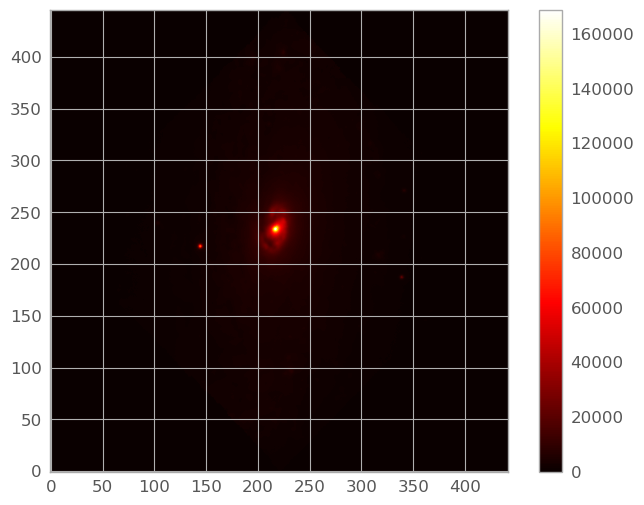

In [5]:
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

new_cube = np.nansum(cube[wave_indices], axis=0)
image_2D = np.squeeze(new_cube) 

#How to label?
plt.figure()
plt.imshow(image_2D, cmap='hot', origin = 'lower')
plt.colorbar()
#This does give an image, so the cube isn't just nan. 
#So why won't nanmean work? Hell, I could MacGyver it

In [6]:
#Order should be:Sqrt all err. At the same time, set bad err pix as high err
#Then find mean in wave range
#Then flatten. Then look for 0s
#Can't look for 0s before mean, because that might remove real 0s

In [10]:
#Ok, THIS is the code for sqrt before avg
#Takes a while to run--jeez, I'm going to start putting time code on all my damn cells
start_time = time.time()#Start timer
err_nx,err_ny,err_nz = err_cube.shape
i=0
j=0
k=0
sqrt_err_cube = np.empty(shape=(err_nx,err_ny,err_nz)) #Sqrt each value in err cube
for i in range(err_nx):
    for j in range(err_ny):
        for k in range(err_nz):
            sqrt_err_cube[i,j,k] = np.sqrt(err_cube[i,j,k])
            if sqrt_err_cube[i,j,k] < 0.0000000001:
                sqrt_err_cube[i,j,k] = 10^12 #Set pix with 0 err to very high err
            k+=1
        j+=1
    i+=1
#End timer
end_time = time.time()
runtime = end_time-start_time
print("Total runtime: ",runtime/60, "minutes")

Total runtime:  13.077343765894572 minutes


In [11]:
print(err_cube.shape,sqrt_err_cube.shape) #Check sqrt err cube same size as original err cube
#Mean of err, along wavelength axis
err_cube_mean = np.nansum(sqrt_err_cube[wave_indices],axis=0) / len(wave_indices) 
err_cube_squeeze = np.squeeze(err_cube_mean)
print(err_cube_squeeze.shape)
err_flat = err_cube_squeeze.flatten() #Flatten error cube
flat_signal = cube_squeeze.flatten() #Flatten signal cube
print(err_flat.shape,flat_signal.shape)

(3682, 446, 442) (3682, 446, 442)
(446, 442)
(197132,) (197132,)


In [12]:
#X and y vectors:
#nx = header['NAXIS1']
#ny = header['NAXIS2']
x_arr = np.arange(nx) 
y_arr = np.arange(ny)
X,Y = np.meshgrid(x_arr, y_arr)
flatx = X.flatten()
flaty = Y.flatten()
print(flatx.shape,flaty.shape)

(197132,) (197132,)


In [13]:
#Remove points where signal=0
count_zero=0
i=0
while i < len(flat_signal)-1:
    if flat_signal[i] < 0.000000000000000001:
        flat_signal = np.delete(flat_signal,i)
        err_flat = np.delete(err_flat,i)
        flatx = np.delete(flatx,i)
        flaty = np.delete(flaty,i)
        #print(i)
    if flat_signal[i] > 0.000000000000000001:
        i+=1
        
i=0
#Check that code has successfully removed 0s
while i < len(flat_signal):
    if flat_signal[i] < 0.000000000000000001:
        count_zero +=1
    i +=1
print("number of zeros: ", count_zero)
print("Percentage of zeros: ", count_zero/len(flat_signal))

number of zeros:  1
Percentage of zeros:  1.0274324463166547e-05


In [14]:
#Check signal to noise
SNtest = np.empty(shape=(nx))
i=0
print(len(err_flat),len(flat_signal))
print("Length of err_flat:",len(err_flat))
while i < len(err_flat)-1:
    SN = flat_signal[i]/err_flat[i]
    if i% 1000==0:
        print(SN)
    SNtest = np.append(SNtest, SN)
    i+=1
    
meanSN = np.nanmean(SNtest)
print("Mean signal to noise: ",meanSN)


97330 97330
Length of err_flat: 97330
1.6520467396967928
10.840222619460375
8.418164809249136
3.4890819150868806
7.694221550845554
16.332776016702958
15.059235462785423
17.509838702022744
16.506832267920988
7.567165114971403
7.369255520795999
2.868674846626498
12.79368938270558
11.24432746658256
15.617557196122418
10.444741461520593
8.376614830501419
10.692860507261347
15.52934495937474
16.50372983890996
4.484525768667944
16.308499266518883
5.390428305871864
12.196837455002258
19.939522955266845
8.957080581122387
3.7802029815788263
3.677081200337292
4.424739359133991
3.4826296030074886
2.8952890414474064
6.040423161871421
12.57724847165127
22.005934413131108
7.048526652883823
3.5296312099513867
22.56874014226549
5.513575426072679
10.535209726958312
11.80856213054012
4.210197906764141
13.051298403798983
7.337331258645547
4.838561773164591
22.20243848738975
2.5388856098756465
9.187610741760132
20.445854519983783
3.394017053990628
4.6279421059123385
37.39140119804103
9.370408500831841
2.6

In [15]:
print("max SNR: ", max(SNtest))
print("min SNR: ", min(SNtest))

max SNR:  8.443331480319662e+252
min SNR:  0.0


In [16]:
#Vorbin is saying that err must be positive and finite
#So, to check what's going wrong:
i=0
for i in range(len(err_flat)):
    if err_flat[i] < 0.0000000001:
        print(i, err_flat[i])
    i+=1
#Ok, so my code earlier missed one bad point
#Manually removing bad point:
err_flat = np.delete(err_flat,97329)
flatx = np.delete(flatx,97329)
flaty = np.delete(flaty,97329)
flat_signal = np.delete(flat_signal,97329)

97329 0.0


In [17]:
flatxy = np.array([flatx,flaty])
print(flatxy.shape)
#save_xy[0,:] = x_gen
#save_xy[1,:] = y_gen

str_SNR = str(50) #Insert target SNR here
np.savetxt("flatxy_arrays_SNR"+str_SNR+".txt",flatxy)

(2, 97329)


In [71]:
SNR = 60. #Set between 20 and 50

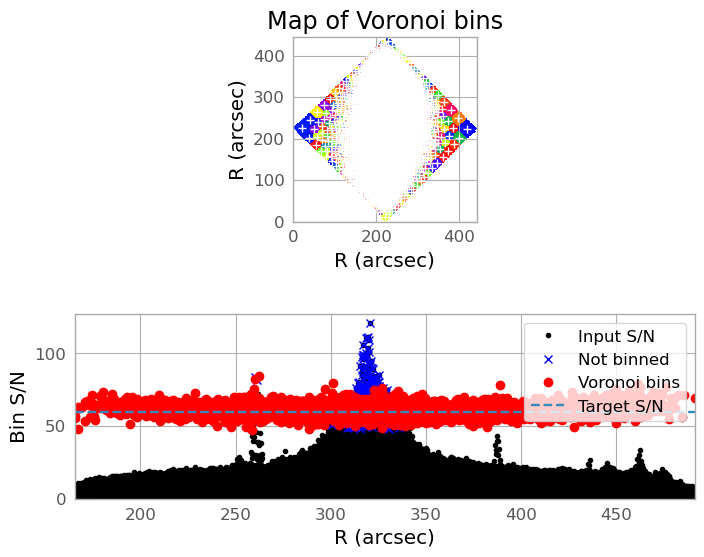

In [72]:
bin_number, x_gen, y_gen, x_bar, y_bar, sn, nPixels, scale = voronoi_2d_binning.voronoi_2d_binning(flatx, flaty, flat_signal, err_flat, SNR,plot=True,pixelsize=1.0)
#Putting pixsize as 0.2 arcsec for now--might need to change


In [73]:
#save the bin_number array, and the coords of center of each bin
#save_xy = np.zeros(2,np.max(bin_number)+1)

save_xy = np.array([x_bar,y_bar])
print(save_xy.shape)
#save_xy[0,:] = x_gen
#save_xy[1,:] = y_gen

str_SNR = str(60) #Insert target SNR here
np.savetxt("xy_coords_SNR"+str_SNR+".txt",save_xy)
np.savetxt("bin_number_SNR"+str_SNR+".txt",bin_number)

#print(len(bin_number))

(2, 4645)


In [74]:
print("Number of bins: ", np.max(bin_number)+1) #Starts counting at 0
#SNR 30: 17,000 bins
#SNR 40: 10,000 bins
#SNR 50: 6,600 bins
#SNR 60: 4,600

Number of bins:  4645


In [75]:
print(cube.shape,err_cube.shape)

(3682, 446, 442) (3682, 446, 442)


In [76]:
#Rebuild into cube with binned signal
i=0
new_cube = np.empty(shape=(nz,ny,nx))
new_err_cube = np.empty(shape=(nz,ny,nx))

start_time = time.time() #Start clock to time how long it takes to run cell

#Max bin-number is the total number of bins
for i in range(np.max(bin_number)+1):
    #i is the number of the bin
    #Find indices in bin i
    bin_ind = np.where(bin_number==i)
    #Find indices in x and y in bin i
    x_ind = flatx[bin_ind]
    y_ind = flaty[bin_ind]
    
    print(i,x_ind,y_ind)
    #Find mean spectrum of bin, for signal and err    
    bin_mean = np.nansum(cube[:,flaty[bin_ind],flatx[bin_ind]], axis=1,keepdims=True) / len(x_ind)
    bin_err_mean = np.nansum(err_cube[:,flaty[bin_ind],flatx[bin_ind]], axis=1,keepdims=True) / len(x_ind)
    
    
    #Assign mean bin spectrum to each pix in bin, in new cubes
    new_cube[:,y_ind,x_ind] = bin_mean
    new_err_cube[:,y_ind,x_ind] = bin_err_mean
    print("Bin", i, "done")
    
    i +=1

#Print how long it took to run cell
end_time = time.time()
runtime = end_time-start_time
print("Total runtime: ",runtime/60, "minutes")
    

0 [218] [235]
Bin 0 done
1 [218] [234]
Bin 1 done
2 [217] [234]
Bin 2 done
3 [217] [235]
Bin 3 done
4 [217] [233]
Bin 4 done
5 [218] [233]
Bin 5 done
6 [216] [234]
Bin 6 done
7 [216] [233]
Bin 7 done
8 [216] [235]
Bin 8 done
9 [217] [232]
Bin 9 done
10 [215] [234]
Bin 10 done
11 [216] [232]
Bin 11 done
12 [215] [233]
Bin 12 done
13 [218] [232]
Bin 13 done
14 [215] [232]
Bin 14 done
15 [215] [235]
Bin 15 done
16 [216] [231]
Bin 16 done
17 [217] [231]
Bin 17 done
18 [214] [233]
Bin 18 done
19 [214] [234]
Bin 19 done
20 [215] [231]
Bin 20 done
21 [214] [232]
Bin 21 done
22 [218] [231]
Bin 22 done
23 [219] [233]
Bin 23 done
24 [219] [232]
Bin 24 done
25 [219] [234]
Bin 25 done
26 [216] [230]
Bin 26 done
27 [217] [230]
Bin 27 done
28 [214] [231]
Bin 28 done
29 [215] [230]
Bin 29 done
30 [218] [230]
Bin 30 done
31 [219] [231]
Bin 31 done
32 [216] [229]
Bin 32 done
33 [217] [229]
Bin 33 done
34 [214] [230]
Bin 34 done
35 [219] [230]
Bin 35 done
36 [215] [229]
Bin 36 done
37 [218] [229]
Bin 37

Bin 271 done
272 [214 214] [213 214]
Bin 272 done
273 [215 215] [213 214]
Bin 273 done
274 [202 202 203] [227 228 228]
Bin 274 done
275 [203 203] [220 221]
Bin 275 done
276 [208 208] [214 215]
Bin 276 done
277 [205 204 205 206] [232 233 233 233]
Bin 277 done
278 [202 203 202] [229 229 230]
Bin 278 done
279 [208 209] [235 235]
Bin 279 done
280 [206 207 206] [234 234 235]
Bin 280 done
281 [202 202] [224 225]
Bin 281 done
282 [213] [236]
Bin 282 done
283 [214] [236]
Bin 283 done
284 [212] [236]
Bin 284 done
285 [202 202] [222 223]
Bin 285 done
286 [203 202 203] [230 231 231]
Bin 286 done
287 [205 205] [216 217]
Bin 287 done
288 [204 204] [217 218]
Bin 288 done
289 [210 210] [213 214]
Bin 289 done
290 [210 211] [236 236]
Bin 290 done
291 [215] [236]
Bin 291 done
292 [202 203 203] [218 218 219]
Bin 292 done
293 [202 202] [220 221]
Bin 293 done
294 [207 207] [214 215]
Bin 294 done
295 [209 209] [213 214]
Bin 295 done
296 [217 217] [213 214]
Bin 296 done
297 [219 219] [214 215]
Bin 297 done
2

Bin 470 done
471 [207 207 208 207 208] [203 204 204 205 205]
Bin 471 done
472 [203 204 203 204 204] [203 203 204 204 205]
Bin 472 done
473 [209 210 209 210] [204 204 205 205]
Bin 473 done
474 [216 217] [208 208]
Bin 474 done
475 [201 201 202 201] [203 204 204 205]
Bin 475 done
476 [187 188 187 188 189 187 188 189] [214 214 215 215 215 216 216 216]
Bin 476 done
477 [185 186 187 185 186 187 186] [219 219 219 220 220 220 221]
Bin 477 done
478 [186 187 186 187 188 186 187 188] [223 223 224 224 224 225 225 225]
Bin 478 done
479 [186 187 188 186 187 188 186 187] [226 226 226 227 227 227 228 228]
Bin 479 done
480 [192 191 192 191 192] [208 209 209 210 210]
Bin 480 done
481 [189 190 189 190 191 190] [210 210 211 211 211 212]
Bin 481 done
482 [211 212 211 212] [204 204 205 205]
Bin 482 done
483 [213 214 214] [205 205 206]
Bin 483 done
484 [197 198 197 198 197] [203 203 204 204 205]
Bin 484 done
485 [195 196 195 196 195 196] [204 204 205 205 206 206]
Bin 485 done
486 [188 187 188 189 187 188 189

Bin 592 done
593 [186 187 186 187 188 186 187 188] [199 199 200 200 200 201 201 201]
Bin 593 done
594 [183 184 185 183 184 185 183 184 185] [201 201 201 202 202 202 203 203 203]
Bin 594 done
595 [203 204 203 204 203] [196 196 197 197 198]
Bin 595 done
596 [188 189 188 189 190 188 189 189] [197 197 198 198 198 199 199 200]
Bin 596 done
597 [178 179 180 178 179 180 178 179 180] [206 206 206 207 207 207 208 208 208]
Bin 597 done
598 [193 193 194 195 193 194] [196 197 197 197 198 198]
Bin 598 done
599 [180 181 182 180 181 182 180 181 182] [202 202 202 203 203 203 204 204 204]
Bin 599 done
600 [207 208 207 208 209 208] [197 197 198 198 198 199]
Bin 600 done
601 [205 206 205 206 206] [196 196 197 197 198]
Bin 601 done
602 [196 197 196 197 196 197] [195 195 196 196 197 197]
Bin 602 done
603 [216 217 216 217] [203 203 204 204]
Bin 603 done
604 [218 217 218] [204 205 205]
Bin 604 done
605 [214 213 214 214] [200 201 201 202]
Bin 605 done
606 [195 194 195 194 195] [194 195 195 196 196]
Bin 606 do

Bin 692 done
693 [183 184 182 183 184 182 183 184 183] [246 246 247 247 247 248 248 248 249]
Bin 693 done
694 [165 166 167 165 166 167 168 165 166 167 168 166 167 168] [208 208 208 209 209 209 209 210 210 210 210 211 211 211]
Bin 694 done
695 [186 187 185 186 187 188 185 186 187 188 186 187] [191 191 192 192 192 192 193 193 193 193 194 194]
Bin 695 done
696 [209 210 211 209 210 210] [196 196 196 197 197 198]
Bin 696 done
697 [207 206 207 208 207 208] [194 195 195 195 196 196]
Bin 697 done
698 [198 199 198 199 200 198 199] [191 191 192 192 192 193 193]
Bin 698 done
699 [204 205 204 205 206 205 206 205] [192 192 193 193 193 194 194 195]
Bin 699 done
700 [172 173 174 175 172 173 174 175 172 173 174 175] [198 198 198 198 199 199 199 199 200 200 200 200]
Bin 700 done
701 [213 212 213 213] [198 199 199 200]
Bin 701 done
702 [215 216 215 216] [201 201 202 202]
Bin 702 done
703 [212 211 212 213 211 212] [196 197 197 197 198 198]
Bin 703 done
704 [192 193 194 192 193 194 192 193 194] [190 190 1

Bin 764 done
765 [163 164 165 162 163 164 165 166 162 163 164 165 166 163 164 165] [241 241 241 242 242 242 242 242 243 243 243 243 243 244 244 244]
Bin 765 done
766 [176 177 178 179 176 177 178 179 176 177 178 177 178] [250 250 250 250 251 251 251 251 252 252 252 253 253]
Bin 766 done
767 [189 188 189 190 188 189 190 188 189 190] [252 253 253 253 254 254 254 255 255 255]
Bin 767 done
768 [202 201 202 203 202] [249 250 250 250 251]
Bin 768 done
769 [180 179 180 179 180 181 179 180 181] [251 252 252 253 253 253 254 254 254]
Bin 769 done
770 [184 185 184 185 186 184 185 186 185] [252 252 253 253 253 254 254 254 255]
Bin 770 done
771 [155 156 154 155 156 153 154 155 156 157 153 154 155 156 157 153 154 155
 156 154 155] [211 211 212 212 212 213 213 213 213 213 214 214 214 214 214 215 215 215
 215 216 216]
Bin 771 done
772 [172 173 174 175 172 173 174 175 172 173 174 175 172 173 174 175] [250 250 250 250 251 251 251 251 252 252 252 252 253 253 253 253]
Bin 772 done
773 [159 158 159 160 161 

Bin 843 done
844 [146 147 148 145 146 147 148 149 145 146 147 148 149 145 146 147 148 149
 147 148] [209 209 209 210 210 210 210 210 211 211 211 211 211 212 212 212 212 212
 213 213]
Bin 844 done
845 [157 158 159 160 156 157 158 159 160 156 157 158 159 160 157 158 159 158] [191 191 191 191 192 192 192 192 192 193 193 193 193 193 194 194 194 195]
Bin 845 done
846 [148 147 148 147 148 149] [214 215 215 216 216 216]
Bin 846 done
847 [171 172 173 171 172 173 170 171 172 173 172] [184 184 184 185 185 185 186 186 186 186 187]
Bin 847 done
848 [185 186 184 185 186 184 185 186 185] [182 182 183 183 183 184 184 184 185]
Bin 848 done
849 [187 188 187 188 189 187 188 189 187] [182 182 183 183 183 184 184 184 185]
Bin 849 done
850 [174 175 176 174 175 176 174 175 176 177 174 175] [183 183 183 184 184 184 185 185 185 185 186 186]
Bin 850 done
851 [177 178 179 177 178 179 177 178 179] [182 182 182 183 183 183 184 184 184]
Bin 851 done
852 [200 201 202 200 201 202 200 201] [186 186 186 187 187 187 18

Bin 912 done
913 [148 149 150 147 148 149 150 151 147 148 149 150 151 146 147 148 149 150
 151 147 148 149 150 151 148 149] [190 190 190 191 191 191 191 191 192 192 192 192 192 193 193 193 193 193
 193 194 194 194 194 194 195 195]
Bin 913 done
914 [170 171 172 173 170 171 172 173 170 171 172 173 171 172 173] [180 180 180 180 181 181 181 181 182 182 182 182 183 183 183]
Bin 914 done
915 [136 137 138 139 140 136 137 138 139 140 136 137 138 139 140 141 136 137
 138 139 140 137 138 139 137 138] [212 212 212 212 212 213 213 213 213 213 214 214 214 214 214 214 215 215
 215 215 215 216 216 216 217 217]
Bin 915 done
916 [139 137 138 139 140 141 136 137 138 139 140 141 136 137 138 139 140 141
 136 137 138 139 140 141 136 137 138 139 140 141 136 137 138 139 140] [205 206 206 206 206 206 207 207 207 207 207 207 208 208 208 208 208 208
 209 209 209 209 209 209 210 210 210 210 210 210 211 211 211 211 211]
Bin 916 done
917 [143 144 145 146 142 143 144 145 146 147 142 143 144 145 146 147 142 143
 144

Bin 956 done
957 [151 152 153 154 155 151 152 153 154 155 150 151 152 153 154 155 149 150
 151 152 153 154 155 150 151 152 153 154 155 151 152 153 154 151 152 153] [255 255 255 255 255 256 256 256 256 256 257 257 257 257 257 257 258 258
 258 258 258 258 258 259 259 259 259 259 259 260 260 260 260 261 261 261]
Bin 957 done
958 [160 161 158 159 160 161 158 159 160 161 162 159 160 161 159 160 161] [259 259 260 260 260 260 261 261 261 261 261 262 262 262 263 263 263]
Bin 958 done
959 [174 172 173 174 175 171 172 173 174 175 172 173 174 175 172 173 174 175] [261 262 262 262 262 263 263 263 263 263 264 264 264 264 265 265 265 265]
Bin 959 done
960 [176 177 178 176 177 178 179 176 177 178 179 176 177 178 179] [262 262 262 263 263 263 263 264 264 264 264 265 265 265 265]
Bin 960 done
961 [163 164 165 162 163 164 165 162 163 164 165 161 162 163 164 165 162 163
 164] [261 261 261 262 262 262 262 263 263 263 263 264 264 264 264 264 265 265
 265]
Bin 961 done
962 [186 187 186 187 188 185 186 187 1

Bin 990 done
991 [150 151 152 153 149 150 151 152 153 154 149 150 151 152 153 154 149 150
 151 152 153 150 151 152 153] [175 175 175 175 176 176 176 176 176 176 177 177 177 177 177 177 178 178
 178 178 178 179 179 179 179]
Bin 991 done
992 [166 165 166 167 165 166 167 168 164 165 166 167 168 166 167] [172 173 173 173 174 174 174 174 175 175 175 175 175 176 176]
Bin 992 done
993 [173 174 175 176 173 174 175 176 173 174 175 176 173 174 175 176] [266 266 266 266 267 267 267 267 268 268 268 268 269 269 269 269]
Bin 993 done
994 [151 152 151 152 153 150 151 152 153 154 149 150 151 152 153 154 155 149
 150 151 152 153 154 155 150 151 152 153 154 155 151 152 153 154 155] [262 262 263 263 263 264 264 264 264 264 265 265 265 265 265 265 265 266
 266 266 266 266 266 266 267 267 267 267 267 267 268 268 268 268 268]
Bin 994 done
995 [127 128 129 126 127 128 129 130 131 125 126 127 128 129 130 131 132 125
 126 127 128 129 130 131 132 125 126 127 128 129 130 131 132 125 126 127
 128 129 130 131 132 

Bin 1018 done
1019 [145 146 147 148 145 146 147 148 149 144 145 146 147 148 149 150 144 145
 146 147 148 149 150 144 145 146 147 148 149 145 146 147 148 149] [266 266 266 266 267 267 267 267 267 268 268 268 268 268 268 268 269 269
 269 269 269 269 269 270 270 270 270 270 270 271 271 271 271 271]
Bin 1019 done
1020 [156 157 158 159 156 157 158 159 160 156 157 158 159 160 156 157 158 159
 160 161 156 157 158 159 160 157 158] [269 269 269 269 270 270 270 270 270 271 271 271 271 271 272 272 272 272
 272 272 273 273 273 273 273 274 274]
Bin 1020 done
1021 [177 178 176 177 178 179 176 177 178 179 177 178 179] [269 269 270 270 270 270 271 271 271 271 272 272 272]
Bin 1021 done
1022 [185 186 184 185 186 184 185 186 184 185 186] [173 173 174 174 174 175 175 175 176 176 176]
Bin 1022 done
1023 [174 175 173 174 175 173 174 175 176 173 174 175 176 174 175] [270 270 271 271 271 272 272 272 272 273 273 273 273 274 274]
Bin 1023 done
1024 [180 181 182 183 180 181 182 183 180 181 182 183] [270 270 270

Bin 1056 done
1057 [133 134 131 132 133 134 135 136 130 131 132 133 134 135 136 137 130 131
 132 133 134 135 136 137 138 130 131 132 133 134 135 136 137 138 130 131
 132 133 134 135 136 137 138 130 131 132 133 134 135 136 137 130 131 132
 133 134 135 136] [264 264 265 265 265 265 265 265 266 266 266 266 266 266 266 266 267 267
 267 267 267 267 267 267 267 268 268 268 268 268 268 268 268 268 269 269
 269 269 269 269 269 269 269 270 270 270 270 270 270 270 270 271 271 271
 271 271 271 271]
Bin 1057 done
1058 [122 123 124 117 118 119 120 121 122 123 124 116 117 118 119 120 121 122
 123 124 125 116 117 118 119 120 121 122 123 124 125 117 118 119 120 121
 122 123 124 125 126 117 118 119 120 121 122 123 124 125 126 118 119 120
 121 122 123 124 125 126 118 119 120 121 122 123 124 125 119 120 121 122
 123 124 125 119 120 121 122 123] [253 253 253 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255
 255 255 255 256 256 256 256 256 256 256 256 256 256 257 257 257 257 257
 257 257 257 257

Bin 1090 done
1091 [124 125 120 121 122 123 124 125 126 119 120 121 122 123 124 125 126 127
 119 120 121 122 123 124 125 126 127 128 119 120 121 122 123 124 125 126
 127 128 129 119 120 121 122 123 124 125 126 127 128 129 120 121 122 123
 124 125 126 127 128 129 120 121 122 123 124 125 126 127 128 129 121 122
 123 124 125 126 127 128 129 121 122 123 124 125 126 127 128 129] [262 262 263 263 263 263 263 263 263 264 264 264 264 264 264 264 264 264
 265 265 265 265 265 265 265 265 265 265 266 266 266 266 266 266 266 266
 266 266 266 267 267 267 267 267 267 267 267 267 267 267 268 268 268 268
 268 268 268 268 268 268 269 269 269 269 269 269 269 269 269 269 270 270
 270 270 270 270 270 270 270 271 271 271 271 271 271 271 271 271]
Bin 1091 done
1092 [100 101 102 103  99 100 101 102 103 104 105 106  98  99 100 101 102 103
 104 105 106  98  99 100 101 102 103 104 105 106  97  98  99 100 101 102
 103 104 105 106 107  97  98  99 100 101 102 103 104 105 106 107  97  98
  99 100 101 102 103 104 10

Bin 1113 done
1114 [109 110 108 109 110 111 112 108 109 110 111 112 113 114 107 108 109 110
 111 112 113 114 106 107 108 109 110 111 112 113 114 106 107 108 109 110
 111 112 113 114 115 106 107 108 109 110 111 112 113 114 115 106 107 108
 109 110 111 112 113 114 115 107 108 109 110 111 112 113 114 108 109 110
 111 112 113 108 109 110 111 112] [178 178 179 179 179 179 179 180 180 180 180 180 180 180 181 181 181 181
 181 181 181 181 182 182 182 182 182 182 182 182 182 183 183 183 183 183
 183 183 183 183 183 184 184 184 184 184 184 184 184 184 184 185 185 185
 185 185 185 185 185 185 185 186 186 186 186 186 186 186 186 187 187 187
 187 187 187 188 188 188 188 188]
Bin 1114 done
1115 [152 153 154 151 152 153 154 155 151 152 153 154 155 151 152 153 154 155
 151 152 153 154 155 151 152 153 154] [160 160 160 161 161 161 161 161 162 162 162 162 162 163 163 163 163 163
 164 164 164 164 164 165 165 165 165]
Bin 1115 done
1116 [141 142 143 144 145 140 141 142 143 144 145 140 141 142 143 144 145 

Bin 1147 done
1148 [88 89 90 91 92 93 94 95 87 88 89 90 91 92 93 94 95 96 97 98 87 88 89 90
 91 92 93 94 95 96 97 98 86 87 88 89 90 91 92 93 94 95 96 97 98 99 86 87
 88 89 90 91 92 93 94 95 96 97 98 99 86 87 88 89 90 91 92 93 94 95 96 97
 98 99 87 88 89 90 91 92 93 94 95 96 97 98 87 88 89 90 91 92 93 94 95 96
 97 88 89 90 91 92 93 94 95 96 97 88 89 90 91 92 93 94 95 96 89 90 91 92
 93 94 95 96] [210 210 210 210 210 210 210 210 211 211 211 211 211 211 211 211 211 211
 211 211 212 212 212 212 212 212 212 212 212 212 212 212 213 213 213 213
 213 213 213 213 213 213 213 213 213 213 214 214 214 214 214 214 214 214
 214 214 214 214 214 214 215 215 215 215 215 215 215 215 215 215 215 215
 215 215 216 216 216 216 216 216 216 216 216 216 216 216 217 217 217 217
 217 217 217 217 217 217 217 218 218 218 218 218 218 218 218 218 218 219
 219 219 219 219 219 219 219 219 220 220 220 220 220 220 220 220]
Bin 1148 done
1149 [115 116 117 118 112 113 114 115 116 117 118 112 113 114 115 116 117 118
 119 1

Bin 1165 done
1166 [117 118 119 120 121 122 123 124 117 118 119 120 121 122 123 124 125 117
 118 119 120 121 122 123 124 125 117 118 119 120 121 122 123 124 125 126
 117 118 119 120 121 122 123 124 125 126 117 118 119 120 121 122 123 124
 125 119 120 121 122 123 124 121 122 123 123] [158 158 158 158 158 158 158 158 159 159 159 159 159 159 159 159 159 160
 160 160 160 160 160 160 160 160 161 161 161 161 161 161 161 161 161 161
 162 162 162 162 162 162 162 162 162 162 163 163 163 163 163 163 163 163
 163 164 164 164 164 164 164 165 165 165 166]
Bin 1166 done
1167 [187 188 189 187 188 189 187 188 189 187 188 189] [166 166 166 167 167 167 168 168 168 169 169 169]
Bin 1167 done
1168 [193 194 195 193 194 195 193 194 195 193 194] [170 170 170 171 171 171 172 172 172 173 173]
Bin 1168 done
1169 [177 178 179 177 178 179 180 177 178 179 180 177 178 179] [160 160 160 161 161 161 161 162 162 162 162 163 163 163]
Bin 1169 done
1170 [171 172 173 169 170 171 172 173 174 169 170 171 172 173 174 170 17

Bin 1179 done
1180 [129 130 131 132 133 128 129 130 131 132 133 134 135 136 128 129 130 131
 132 133 134 135 136 128 129 130 131 132 133 134 135 136 128 129 130 131
 132 133 134 135 128 129 130 131 132 133 134 135 129 130 131 132 133 134
 135 129 130 131 132 133 134 129 130 131 132] [280 280 280 280 280 281 281 281 281 281 281 281 281 281 282 282 282 282
 282 282 282 282 282 283 283 283 283 283 283 283 283 283 284 284 284 284
 284 284 284 284 285 285 285 285 285 285 285 285 286 286 286 286 286 286
 286 287 287 287 287 287 287 288 288 288 288]
Bin 1180 done
1181 [137 138 137 138 139 140 137 138 139 140 141 142 136 137 138 139 140 141
 142 143 136 137 138 139 140 141 142 143 136 137 138 139 140 141 142 143
 136 137 138 139 140 141 142 143 144 137 138 139 140 141 142 143 138 139
 140 141 142 139 140 141 142] [281 281 282 282 282 282 283 283 283 283 283 283 284 284 284 284 284 284
 284 284 285 285 285 285 285 285 285 285 286 286 286 286 286 286 286 286
 287 287 287 287 287 287 287 287 287 

Bin 1194 done
1195 [121 122 123 124 125 126 127 121 122 123 124 125 126 127 120 121 122 123
 124 125 126 127 120 121 122 123 124 125 126 127 119 120 121 122 123 124
 125 126 127 128 119 120 121 122 123 124 125 126 127 128 120 121 122 123
 124 125 126 127 128 121 122 123 124 125 126 122 123 124] [282 282 282 282 282 282 282 283 283 283 283 283 283 283 284 284 284 284
 284 284 284 284 285 285 285 285 285 285 285 285 286 286 286 286 286 286
 286 286 286 286 287 287 287 287 287 287 287 287 287 287 288 288 288 288
 288 288 288 288 288 289 289 289 289 289 289 290 290 290]
Bin 1195 done
1196 [183 184 185 182 183 184 185 182 183 184 185 183 184 185] [276 276 276 277 277 277 277 278 278 278 278 279 279 279]
Bin 1196 done
1197 [144 145 146 147 148 149 143 144 145 146 147 148 149 143 144 145 146 147
 148 149 143 144 145 146 147 148 149 144 145 146 147 148 149 145 146 147] [288 288 288 288 288 288 289 289 289 289 289 289 289 290 290 290 290 290
 290 290 291 291 291 291 291 291 291 292 292 292 292 

Bin 1211 done
1212 [66 67 68 69 70 71 72 73 65 66 67 68 69 70 71 72 73 65 66 67 68 69 70 71
 72 73 74 64 65 66 67 68 69 70 71 72 73 74 63 64 65 66 67 68 69 70 71 72
 73 74 75 62 63 64 65 66 67 68 69 70 71 72 73 74 75 61 62 63 64 65 66 67
 68 69 70 71 72 73 74 75 76 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 62 63 64 65 66 67 68 69 70 71 72 73 74 62 63
 64 65 66 67 68 69 70 71 72 73 63 64 65 66 67 68 69 70 71 72 73 64 65 66
 67] [206 206 206 206 206 206 206 206 207 207 207 207 207 207 207 207 207 208
 208 208 208 208 208 208 208 208 208 209 209 209 209 209 209 209 209 209
 209 209 210 210 210 210 210 210 210 210 210 210 210 210 210 211 211 211
 211 211 211 211 211 211 211 211 211 211 211 212 212 212 212 212 212 212
 212 212 212 212 212 212 21

Bin 1219 done
1220 [59 60 61 57 58 59 60 61 62 55 56 57 58 59 60 61 62 63 53 54 55 56 57 58
 59 60 61 62 63 64 53 54 55 56 57 58 59 60 61 62 63 64 65 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67
 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 54 55 56 57 58 59 60 61 62 63 64 65 66 67 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 54 55 56 57 58 59 60 61 62 63 64 65 66 55 56
 57 58 59 60 61 62 63 64 65 66 55 56 57 58 59 60 61 62 63 64 65 57 58 59
 60 61 62 63 64 65] [231 231 231 232 232 232 232 232 232 233 233 233 233 233 233 233 233 233
 234 234 234 234 234 234 234 234 234 234 234 234 235 235 235 235 235 235
 235 235 235 235 235 235 235 236 236 236 236 236 236 236 236 236 236 236
 236 236 236

Bin 1229 done
1230 [154 155 156 152 153 154 155 156 157 158 152 153 154 155 156 157 158 152
 153 154 155 156 157 158 152 153 154 155 156 157 153 154 155 156 155] [293 293 293 294 294 294 294 294 294 294 295 295 295 295 295 295 295 296
 296 296 296 296 296 296 297 297 297 297 297 297 298 298 298 298 299]
Bin 1230 done
1231 [131 132 133 130 131 132 133 134 135 136 129 130 131 132 133 134 135 136
 128 129 130 131 132 133 134 135 136 137 128 129 130 131 132 133 134 135
 136 137 138 128 129 130 131 132 133 134 135 136 137 138 128 129 130 131
 132 133 134 135 136 137 128 129 130 131 132 133 134 135 129 130 131 132
 133 134 131 132 133] [295 295 295 296 296 296 296 296 296 296 297 297 297 297 297 297 297 297
 298 298 298 298 298 298 298 298 298 298 299 299 299 299 299 299 299 299
 299 299 299 300 300 300 300 300 300 300 300 300 300 300 301 301 301 301
 301 301 301 301 301 301 302 302 302 302 302 302 302 302 303 303 303 303
 303 303 304 304 304]
Bin 1231 done
1232 [161 162 160 161 162 163 164 

Bin 1239 done
1240 [101 102 103  99 100 101 102 103 104  99 100 101 102 103 104 105 106  99
 100 101 102 103 104 105 106 107 108 109  98  99 100 101 102 103 104 105
 106 107 108 109 110  98  99 100 101 102 103 104 105 106 107 108 109 110
  98  99 100 101 102 103 104 105 106 107 108 109 110  98  99 100 101 102
 103 104 105 106 107 108 109 110  99 100 101 102 103 104 105 106 107 108
 109  99 100 101 102 103 104 105 106 107 108  99 100 101 102 103 104 105
 106 107 108  99 100 101 102 103 104 105 106 107 102 103 104 105 106] [289 289 289 290 290 290 290 290 290 291 291 291 291 291 291 291 291 292
 292 292 292 292 292 292 292 292 292 292 293 293 293 293 293 293 293 293
 293 293 293 293 293 294 294 294 294 294 294 294 294 294 294 294 294 294
 295 295 295 295 295 295 295 295 295 295 295 295 295 296 296 296 296 296
 296 296 296 296 296 296 296 296 297 297 297 297 297 297 297 297 297 297
 297 298 298 298 298 298 298 298 298 298 298 299 299 299 299 299 299 299
 299 299 299 300 300 300 300 300 30

Bin 1245 done
1246 [102 103 101 102 103 104 100 101 102 103 104 105 106  99 100 101 102 103
 104 105 106 107  98  99 100 101 102 103 104 105 106 107  97  98  99 100
 101 102 103 104 105 106 107  97  98  99 100 101 102 103 104 105 106 107
  97  98  99 100 101 102 103 104 105 106 107  97  98  99 100 101 102 103
 104 105 106 107  98  99 100 101 102 103 104 105 106 107 108  98  99 100
 101 102 103 104 105 106 107  99 100 101 102 103 104 105 106 102 103 104
 105] [147 147 148 148 148 148 149 149 149 149 149 149 149 150 150 150 150 150
 150 150 150 150 151 151 151 151 151 151 151 151 151 151 152 152 152 152
 152 152 152 152 152 152 152 153 153 153 153 153 153 153 153 153 153 153
 154 154 154 154 154 154 154 154 154 154 154 155 155 155 155 155 155 155
 155 155 155 155 156 156 156 156 156 156 156 156 156 156 156 157 157 157
 157 157 157 157 157 157 157 158 158 158 158 158 158 158 158 159 159 159
 159]
Bin 1246 done
1247 [68 69 70 68 69 70 71 66 67 68 69 70 71 72 66 67 68 69 70 71 72 73 64 65
 

Bin 1256 done
1257 [151 152 149 150 151 152 153 154 148 149 150 151 152 153 154 148 149 150
 151 152 153 149 150 151 152 153 151 152] [298 298 299 299 299 299 299 299 300 300 300 300 300 300 300 301 301 301
 301 301 301 302 302 302 302 302 303 303]
Bin 1257 done
1258 [159 158 159 160 161 157 158 159 160 161 162 156 157 158 159 160 161 162
 157 158 159 160 161 162 158 159 160 161 159 160] [296 297 297 297 297 298 298 298 298 298 298 299 299 299 299 299 299 299
 300 300 300 300 300 300 301 301 301 301 302 302]
Bin 1258 done
1259 [40 39 40 41 38 39 40 41 37 38 39 40 41 42 36 37 38 39 40 41 42 43 35 36
 37 38 39 40 41 42 43 44 34 35 36 37 38 39 40 41 42 43 44 45 33 34 35 36
 37 38 39 40 41 42 43 44 45 46 32 33 34 35 36 37 38 39 40 41 42 43 44 45
 46 47 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 28 29 30 31 32 33 34 35 36
 37 38 39 40 41 42 43 44 45 4

Bin 1266 done
1267 [143 144 142 143 144 145 142 143 144 145 146 141 142 143 144 145 146 141
 142 143 144 145 146 141 142 143 144 145 146 142 143 144 145 146 143] [138 138 139 139 139 139 140 140 140 140 140 141 141 141 141 141 141 142
 142 142 142 142 142 143 143 143 143 143 143 144 144 144 144 144 145]
Bin 1267 done
1268 [166 165 166 167 168 164 165 166 167 168 165 166 167 168 165 166 167] [148 149 149 149 149 150 150 150 150 150 151 151 151 151 152 152 152]
Bin 1268 done
1269 [153 154 155 156 153 154 155 156 153 154 155 156 157 153 154 155 156 157
 154 155 156] [143 143 143 143 144 144 144 144 145 145 145 145 145 146 146 146 146 146
 147 147 147]
Bin 1269 done
1270 [148 149 150 151 147 148 149 150 151 147 148 149 150 151 152 147 148 149
 150 151 152 147 148 149 150 151 152 148 149] [140 140 140 140 141 141 141 141 141 142 142 142 142 142 142 143 143 143
 143 143 143 144 144 144 144 144 144 145 145]
Bin 1270 done
1271 [138 139 137 138 139 140 136 137 138 139 140 141 142 136 137 138 13

Bin 1303 done
1304 [200 201 199 200 201 202 199 200 201] [175 175 176 176 176 176 177 177 177]
Bin 1304 done
1305 [142 143 144 141 142 143 144 145 140 141 142 143 144 145 146 139 140 141
 142 143 144 145 146 139 140 141 142 143 144 145 140 141 142 143 144 145
 141 142 143 144] [131 131 131 132 132 132 132 132 133 133 133 133 133 133 133 134 134 134
 134 134 134 134 134 135 135 135 135 135 135 135 136 136 136 136 136 136
 137 137 137 137]
Bin 1305 done
1306 [157 158 159 160 157 158 159 160 157 158 159 160 157 158 159 160] [138 138 138 138 139 139 139 139 140 140 140 140 141 141 141 141]
Bin 1306 done
1307 [174 175 173 174 175 176 177 173 174 175 176 177 173 174 175 176 177 173
 174 175 176 177] [146 146 147 147 147 147 147 148 148 148 148 148 149 149 149 149 149 150
 150 150 150 150]
Bin 1307 done
1308 [202 203 201 202 203 204 201 202 203 204] [177 177 178 178 178 178 179 179 179 179]
Bin 1308 done
1309 [196 197 198 196 197 198 199 196 197 198] [168 168 168 169 169 169 169 170 170 170]


Bin 1333 done
1334 [200 201 202 200 201 202 200 201 202 201] [270 270 270 271 271 271 272 272 272 273]
Bin 1334 done
1335 [177 178 179 180 181 177 178 179 180 177 178 179 180 177 178 179 180] [294 294 294 294 294 295 295 295 295 296 296 296 296 297 297 297 297]
Bin 1335 done
1336 [158 159 160 157 158 159 160 156 157 158 159 160 161 156 157 158 159 160
 161 157 158 159 160 161 158 159 160] [304 304 304 305 305 305 305 306 306 306 306 306 306 307 307 307 307 307
 307 308 308 308 308 308 309 309 309]
Bin 1336 done
1337 [193 194 195 193 194 195 196 193 194 195] [279 279 279 280 280 280 280 281 281 281]
Bin 1337 done
1338 [208 209 208 209] [254 254 255 255]
Bin 1338 done
1339 [206 207 205 206 207 206] [260 260 261 261 261 262]
Bin 1339 done
1340 [190 191 192 190 191 192 190 191 192] [161 161 161 162 162 162 163 163 163]
Bin 1340 done
1341 [186 187 185 186 187 188 185 186 187 188 186 187] [156 156 157 157 157 157 158 158 158 158 159 159]
Bin 1341 done
1342 [189 190 188 189 190 188 189 190 19

Bin 1409 done
1410 [215] [244]
Bin 1410 done
1411 [214] [248]
Bin 1411 done
1412 [186 187 186 187 188 186 187 188 189 186 187 188] [291 291 292 292 292 293 293 293 293 294 294 294]
Bin 1412 done
1413 [211 212 212] [257 257 258]
Bin 1413 done
1414 [205 206 207 204 205 206 207 205 206 207] [176 176 176 177 177 177 177 178 178 178]
Bin 1414 done
1415 [216] [240]
Bin 1415 done
1416 [209 208 209 210 209] [263 264 264 264 265]
Bin 1416 done
1417 [213 214 213 214 213 214] [194 194 195 195 196 196]
Bin 1417 done
1418 [215 216] [245 245]
Bin 1418 done
1419 [185 186 184 185 186 187 184 185 186 187 185 186] [152 152 153 153 153 153 154 154 154 154 155 155]
Bin 1419 done
1420 [214 215 214 215 214 215] [197 197 198 198 199 199]
Bin 1420 done
1421 [214] [249]
Bin 1421 done
1422 [210 210 211 210] [260 261 261 262]
Bin 1422 done
1423 [216] [241]
Bin 1423 done
1424 [212 213 212 213 211 212 213] [188 188 189 189 190 190 190]
Bin 1424 done
1425 [205 206 207 206 207 208 206 207] [270 270 270 271 271 271 2

Bin 1495 done
1496 [217 218] [248 248]
Bin 1496 done
1497 [219] [238]
Bin 1497 done
1498 [215 216] [255 255]
Bin 1498 done
1499 [210 211 212 210 211 212 211] [267 267 267 268 268 268 269]
Bin 1499 done
1500 [215 214 215] [257 258 258]
Bin 1500 done
1501 [215 216 215 216 215 216] [194 194 195 195 196 196]
Bin 1501 done
1502 [219] [239]
Bin 1502 done
1503 [211 212 213 211 212 213 212 213] [185 185 185 186 186 186 187 187]
Bin 1503 done
1504 [219] [240]
Bin 1504 done
1505 [207 205 206 207 208 206 207] [275 276 276 276 276 277 277]
Bin 1505 done
1506 [188 189 190 187 188 189 190 188 189 190 189] [154 154 154 155 155 155 155 156 156 156 157]
Bin 1506 done
1507 [203 204 202 203 204 205 202 203 204] [169 169 170 170 170 170 171 171 171]
Bin 1507 done
1508 [216 217] [253 253]
Bin 1508 done
1509 [215 216] [256 256]
Bin 1509 done
1510 [208 209 210 208 209 210 208 209] [178 178 178 179 179 179 180 180]
Bin 1510 done
1511 [217 216 217 218 216 217] [196 197 197 197 198 198]
Bin 1511 done
1512 [219]

Bin 1603 done
1604 [213 214 215 213 214 215 213 214 215] [182 182 182 183 183 183 184 184 184]
Bin 1604 done
1605 [215 215 216] [262 263 263]
Bin 1605 done
1606 [204 205 203 204 205 206 203 204 205] [166 166 167 167 167 167 168 168 168]
Bin 1606 done
1607 [222] [236]
Bin 1607 done
1608 [195 196 194 195 196 193 194 195 196 196] [155 155 156 156 156 157 157 157 157 158]
Bin 1608 done
1609 [219 220 218 219 220] [195 195 196 196 196]
Bin 1609 done
1610 [219 220 221 220 221] [199 199 199 200 200]
Bin 1610 done
1611 [221] [243]
Bin 1611 done
1612 [186 187 186 187 188 186 187 188 186 187] [147 147 148 148 148 149 149 149 150 150]
Bin 1612 done
1613 [222] [237]
Bin 1613 done
1614 [163 164 165 166 163 164 165 166 167 162 163 164 165 166 167 163 164 165
 166 164] [312 312 312 312 313 313 313 313 313 314 314 314 314 314 314 315 315 315
 315 316]
Bin 1614 done
1615 [201 202 203 201 202 203 201 202 203] [286 286 286 287 287 287 288 288 288]
Bin 1615 done
1616 [216 217 218 216 217 218 216 217 218] [

Bin 1723 done
1724 [223] [245]
Bin 1724 done
1725 [225 226 225] [218 218 219]
Bin 1725 done
1726 [224] [240]
Bin 1726 done
1727 [225 225] [231 232]
Bin 1727 done
1728 [120 121 122 119 120 121 122 123 124 118 119 120 121 122 123 124 125 126
 117 118 119 120 121 122 123 124 125 126 116 117 118 119 120 121 122 123
 124 125 126 115 116 117 118 119 120 121 122 123 124 125 126 114 115 116
 117 118 119 120 121 122 123 124 125 126 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 112 113 114 115 116 117 118 119 120 121 122 123 124 125 113 114 115
 116 117 118 119 120 121 122 123 124 113 114 115 116 117 118 119 120 121
 122 123 115 116 117 118 119 120 121 122 116 117 118 119 120 121 118 119
 120 119] [323 323 323 324 324 324 324 324 324 325 325 325 325 325 325 325 325 325
 326 326 326 326 326 326 326 326 326 326 327 327 327 327 327 327 327 327
 327 327 327 328 328

Bin 1849 done
1850 [180 179 180 178 179 180 181 178 179 180 181 178 179 180 181 178 179 180
 181] [308 309 309 310 310 310 310 311 311 311 311 312 312 312 312 313 313 313
 313]
Bin 1850 done
1851 [208 209 207 208 209 210 208 209 210] [284 284 285 285 285 285 286 286 286]
Bin 1851 done
1852 [225] [248]
Bin 1852 done
1853 [227] [237]
Bin 1853 done
1854 [224 225] [252 252]
Bin 1854 done
1855 [227 228 226 227 228 227] [207 207 208 208 208 209]
Bin 1855 done
1856 [219 220 221 219 220 221 219 220 221] [184 184 184 185 185 185 186 186 186]
Bin 1856 done
1857 [221 222 221] [261 261 262]
Bin 1857 done
1858 [210 209 210 211 212 209 210 211 212 209 210 211] [166 167 167 167 167 168 168 168 168 169 169 169]
Bin 1858 done
1859 [190 191 189 190 191 192 189 190 191 192 189 190 191] [146 146 147 147 147 147 148 148 148 148 149 149 149]
Bin 1859 done
1860 [227] [238]
Bin 1860 done
1861 [215 216 217 215 216 217 215 216 217 218 216] [176 176 176 177 177 177 178 178 178 178 179]
Bin 1861 done
1862 [225 22

Bin 1969 done
1970 [208 209 210 207 208 209 210 207 208 209 210 208 209] [287 287 287 288 288 288 288 289 289 289 289 290 290]
Bin 1970 done
1971 [223 224 223 224] [262 262 263 263]
Bin 1971 done
1972 [226 225 226] [256 257 257]
Bin 1972 done
1973 [226 227] [254 254]
Bin 1973 done
1974 [231 230 231 232] [215 216 216 216]
Bin 1974 done
1975 [217 218 216 217 218 217 218] [275 275 276 276 276 277 277]
Bin 1975 done
1976 [229 230] [242 242]
Bin 1976 done
1977 [228 229] [247 247]
Bin 1977 done
1978 [222 221 222 223 222] [266 267 267 267 268]
Bin 1978 done
1979 [194 195 196 193 194 195 196 194 195 196 197 194 195 196 195] [301 301 301 302 302 302 302 303 303 303 303 304 304 304 305]
Bin 1979 done
1980 [133 131 132 133 129 130 131 132 133 134 127 128 129 130 131 132 133 134
 135 127 128 129 130 131 132 133 134 135 136 127 128 129 130 131 132 133
 134 135 136 127 128 129 130 131 132 133 134 135 136 127 128 129 130 131
 132 133 134 135 128 129 130 131 132 133 134 135 128 129 130 131 132 133
 13

Bin 2077 done
2078 [211 212 213 214 211 212 213 214 212 213] [288 288 288 288 289 289 289 289 290 290]
Bin 2078 done
2079 [182 183 184 185 182 183 184 185 181 182 183 184 185 182 183 184 185 182
 183 184] [312 312 312 312 313 313 313 313 314 314 314 314 314 315 315 315 315 316
 316 316]
Bin 2079 done
2080 [232 233 232 233] [241 241 242 242]
Bin 2080 done
2081 [234 233 234] [231 232 232]
Bin 2081 done
2082 [230 231] [251 251]
Bin 2082 done
2083 [226 227 226 227] [263 263 264 264]
Bin 2083 done
2084 [233 234 233] [233 233 234]
Bin 2084 done
2085 [234 235 233 234 235] [217 217 218 218 218]
Bin 2085 done
2086 [206 205 206 207 208 205 206 207 208 205 206 207] [294 295 295 295 295 296 296 296 296 297 297 297]
Bin 2086 done
2087 [223 224 225 224 225] [270 270 270 271 271]
Bin 2087 done
2088 [170 171 172 169 170 171 172 173 169 170 171 172 173 169 170 171 172 173
 170 171 172] [318 318 318 319 319 319 319 319 320 320 320 320 320 321 321 321 321 321
 322 322 322]
Bin 2088 done
2089 [234 233 234

Bin 2171 done
2172 [166 167 164 165 166 167 168 164 165 166 167 168 164 165 166 167 168 165
 166 167 168] [126 126 127 127 127 127 127 128 128 128 128 128 129 129 129 129 129 130
 130 130 130]
Bin 2172 done
2173 [228 229 227 228 229 230 228 229] [184 184 185 185 185 185 186 186]
Bin 2173 done
2174 [151 152 153 154 155 151 152 153 154 155 156 150 151 152 153 154 155 156
 150 151 152 153 154 155 156 150 151 152 153 154 155 156 151 152 153 154
 155 152 153] [122 122 122 122 122 123 123 123 123 123 123 124 124 124 124 124 124 124
 125 125 125 125 125 125 125 126 126 126 126 126 126 126 127 127 127 127
 127 128 128]
Bin 2174 done
2175 [236 235 236 237 236] [212 213 213 213 214]
Bin 2175 done
2176 [231 232 233 231 232 233 231 232] [193 193 193 194 194 194 195 195]
Bin 2176 done
2177 [234 233 234 235 233 234 235] [200 201 201 201 202 202 202]
Bin 2177 done
2178 [169 170 171 169 170 171 172 169 170 171 172 169 170 171 172 170 171 172] [128 128 128 129 129 129 129 130 130 130 130 131 131 131 13

Bin 2243 done
2244 [237 235 236 237 238 236 237] [199 200 200 200 200 201 201]
Bin 2244 done
2245 [239 240 238 239 240] [218 218 219 219 219]
Bin 2245 done
2246 [235 234 235 236 234 235] [192 193 193 193 194 194]
Bin 2246 done
2247 [217 218 217 218 219 217 218 219 217 218 219] [159 159 160 160 160 161 161 161 162 162 162]
Bin 2247 done
2248 [222 223 221 222 223 224 222 223] [280 280 281 281 281 281 282 282]
Bin 2248 done
2249 [217 215 216 217 218 216 217 218] [288 289 289 289 289 290 290 290]
Bin 2249 done
2250 [234 233 234 235 233 234] [256 257 257 257 258 258]
Bin 2250 done
2251 [234 235 234 235] [254 254 255 255]
Bin 2251 done
2252 [190 191 192 193 190 191 192 193 190 191 192 193 190 191 192 193] [136 136 136 136 137 137 137 137 138 138 138 138 139 139 139 139]
Bin 2252 done
2253 [219 220 221 219 220 221 219 220 221] [284 284 284 285 285 285 286 286 286]
Bin 2253 done
2254 [237 238 239 238] [242 242 242 243]
Bin 2254 done
2255 [239 240 238 239 240] [234 234 235 235 235]
Bin 2255 don

Bin 2324 done
2325 [242 243 241 242 243 242] [223 223 224 224 224 225]
Bin 2325 done
2326 [240 241 240 241] [244 244 245 245]
Bin 2326 done
2327 [242 242 243 241 242 243] [220 221 221 222 222 222]
Bin 2327 done
2328 [232 233 231 232 233 232] [267 267 268 268 268 269]
Bin 2328 done
2329 [232 233 234 235 232 233 234 235 233 234] [181 181 181 181 182 182 182 182 183 183]
Bin 2329 done
2330 [242 243 241 242 243] [227 227 228 228 228]
Bin 2330 done
2331 [221 220 221 222 220 221 222 220 221 222] [159 160 160 160 161 161 161 162 162 162]
Bin 2331 done
2332 [240 241 239 240 241 240 241] [198 198 199 199 199 200 200]
Bin 2332 done
2333 [238 239 238 239] [249 249 250 250]
Bin 2333 done
2334 [241 242 241 242] [217 217 218 218]
Bin 2334 done
2335 [242 243 241 242 243 242] [229 229 230 230 230 231]
Bin 2335 done
2336 [234 233 234 235 234] [263 264 264 264 265]
Bin 2336 done
2337 [240 241 240 241 242 240 241] [206 206 207 207 207 208 208]
Bin 2337 done
2338 [228 229 227 228 229 228] [275 275 276 276

Bin 2407 done
2408 [243 242 243 244 242 243 244] [204 205 205 205 206 206 206]
Bin 2408 done
2409 [215 215 216 217 215 216 217 215 216 217] [296 297 297 297 298 298 298 299 299 299]
Bin 2409 done
2410 [228 229 227 228 229 228 229] [280 280 281 281 281 282 282]
Bin 2410 done
2411 [242 242 243 243] [244 245 245 246]
Bin 2411 done
2412 [149 147 148 149 150 151 145 146 147 148 149 150 151 152 145 146 147 148
 149 150 151 152 145 146 147 148 149 150 151 152 145 146 147 148 149 150
 151 152 145 146 147 148 149 150 151 147 148 149 150 148 149] [327 328 328 328 328 328 329 329 329 329 329 329 329 329 330 330 330 330
 330 330 330 330 331 331 331 331 331 331 331 331 332 332 332 332 332 332
 332 332 333 333 333 333 333 333 333 334 334 334 334 335 335]
Bin 2412 done
2413 [244 245 244 245] [239 239 240 240]
Bin 2413 done
2414 [233 234 232 233 234 233 234] [272 272 273 273 273 274 274]
Bin 2414 done
2415 [244 245 244 245 244 245] [222 222 223 223 224 224]
Bin 2415 done
2416 [245 246 244 245 246 245]

Bin 2478 done
2479 [239 240 241 239 240 241] [262 262 262 263 263 263]
Bin 2479 done
2480 [220 221 219 220 221 222 220 221] [293 293 294 294 294 294 295 295]
Bin 2480 done
2481 [245 243 244 245 246 244 245] [249 250 250 250 250 251 251]
Bin 2481 done
2482 [227 228 226 227 228 226 227 228] [286 286 287 287 287 288 288 288]
Bin 2482 done
2483 [247 248 246 247 248 246 247] [232 232 233 233 233 234 234]
Bin 2483 done
2484 [241 241 242 241 242] [257 258 258 259 259]
Bin 2484 done
2485 [223 224 222 223 224 222 223 224 223 224] [291 291 292 292 292 293 293 293 294 294]
Bin 2485 done
2486 [167 168 169 166 167 168 169 170 166 167 168 169 170 171 166 167 168 169
 170 171 167 168 169 170 171 168] [118 118 118 119 119 119 119 119 120 120 120 120 120 120 121 121 121 121
 121 121 122 122 122 122 122 123]
Bin 2486 done
2487 [246 245 246 247 244 245 246 247 246] [199 200 200 200 201 201 201 201 202]
Bin 2487 done
2488 [246 247 245 246 247 245 246 247] [204 204 205 205 205 206 206 206]
Bin 2488 done
24

Bin 2558 done
2559 [249 250 251 249 250 251 249 250] [220 220 220 221 221 221 222 222]
Bin 2559 done
2560 [247 248 249 247 248 249 248] [198 198 198 199 199 199 200]
Bin 2560 done
2561 [249 250 248 249 250 251 249 250] [208 208 209 209 209 209 210 210]
Bin 2561 done
2562 [250 251 249 250 251 252 250 251] [227 227 228 228 228 228 229 229]
Bin 2562 done
2563 [242 243 244 242 243 244 242 243] [262 262 262 263 263 263 264 264]
Bin 2563 done
2564 [207 208 209 206 207 208 209 210 206 207 208 209 210 207 208 209 210] [308 308 308 309 309 309 309 309 310 310 310 310 310 311 311 311 311]
Bin 2564 done
2565 [250 251 252 250 251 252 250 251 252] [217 217 217 218 218 218 219 219 219]
Bin 2565 done
2566 [225 225 226 227 225 226 227 225 226 227] [291 292 292 292 293 293 293 294 294 294]
Bin 2566 done
2567 [249 250 251 249 250 251] [232 232 232 233 233 233]
Bin 2567 done
2568 [193 194 193 194 195 192 193 194 195 196 192 193 194 195 193 194 195] [317 317 318 318 318 319 319 319 319 319 320 320 320 320

Bin 2639 done
2640 [185 186 184 185 186 187 184 185 186 187 188 184 185 186 187 185 186 187] [121 121 122 122 122 122 123 123 123 123 123 124 124 124 124 125 125 125]
Bin 2640 done
2641 [243 244 242 243 244 243] [270 270 271 271 271 272]
Bin 2641 done
2642 [240 241 242 240 241 242 243 240 241 242] [173 173 173 174 174 174 174 175 175 175]
Bin 2642 done
2643 [240 241 239 240 241 242 239 240 241] [170 170 171 171 171 171 172 172 172]
Bin 2643 done
2644 [248 249 248 249 247 248 249 250 248 249] [188 188 189 189 190 190 190 190 191 191]
Bin 2644 done
2645 [249 250 249 250 251 249 250] [255 255 256 256 256 257 257]
Bin 2645 done
2646 [229 230 231 229 230 231 229 230] [156 156 156 157 157 157 158 158]
Bin 2646 done
2647 [254 253 254 255 252 253 254 255 253 254] [211 212 212 212 213 213 213 213 214 214]
Bin 2647 done
2648 [251 252 250 251 252 250 251 252] [248 248 249 249 249 250 250 250]
Bin 2648 done
2649 [247 246 247 248 246 247 248 246 247 248] [184 185 185 185 186 186 186 187 187 187]
Bi

Bin 2707 done
2708 [245 246 247 245 246 247 246] [271 271 271 272 272 272 273]
Bin 2708 done
2709 [256 255 256 257 255 256 257 255 256 257] [219 220 220 220 221 221 221 222 222 222]
Bin 2709 done
2710 [180 181 182 183 184 180 181 182 183 184 180 181 182 183 184 180 181 182
 183 184 181 182 183] [328 328 328 328 328 329 329 329 329 329 330 330 330 330 330 331 331 331
 331 331 332 332 332]
Bin 2710 done
2711 [127 128 129 126 127 128 129 130 131 132 133 134 125 126 127 128 129 130
 131 132 133 134 135 124 125 126 127 128 129 130 131 132 133 134 135 136
 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 120 121 122 123 124 125 126 127
 128 1

Bin 2764 done
2765 [232 233 234 231 232 233 234 232 233] [154 154 154 155 155 155 155 156 156]
Bin 2765 done
2766 [258 259 260 257 258 259 260 258 259] [231 231 231 232 232 232 232 233 233]
Bin 2766 done
2767 [258 259 260 258 259 260 258 259 260] [219 219 219 220 220 220 221 221 221]
Bin 2767 done
2768 [247 248 246 247 248 246 247 248] [273 273 274 274 274 275 275 275]
Bin 2768 done
2769 [209 210 211 208 209 210 211 208 209 210 211 208 209 210 211] [316 316 316 317 317 317 317 318 318 318 318 319 319 319 319]
Bin 2769 done
2770 [235 234 235 236 234 235 236 237 234 235 236] [155 156 156 156 157 157 157 157 158 158 158]
Bin 2770 done
2771 [228 229 230 228 229 230 231 228 229 230] [300 300 300 301 301 301 301 302 302 302]
Bin 2771 done
2772 [198 199 200 197 198 199 200 197 198 199 200 197 198 199 200 198] [323 323 323 324 324 324 324 325 325 325 325 326 326 326 326 327]
Bin 2772 done
2773 [248 249 250 248 249 250 248 249] [270 270 270 271 271 271 272 272]
Bin 2773 done
2774 [252 253 254 2

Bin 2833 done
2834 [262 263 260 261 262 263 264 261 262 263 264 261 262 263 264] [217 217 218 218 218 218 218 219 219 219 219 220 220 220 220]
Bin 2834 done
2835 [201 202 203 201 202 203 204 201 202 203 204 202 203] [323 323 323 324 324 324 324 325 325 325 325 326 326]
Bin 2835 done
2836 [253 254 255 253 254 255 253 254 255] [265 265 265 266 266 266 267 267 267]
Bin 2836 done
2837 [205 206 207 204 205 206 207 208 204 205 206 207 208 205 206 207 208 206
 207] [321 321 321 322 322 322 322 322 323 323 323 323 323 324 324 324 324 325
 325]
Bin 2837 done
2838 [247 248 246 247 248 246 247 248] [279 279 280 280 280 281 281 281]
Bin 2838 done
2839 [258 259 260 257 258 259 260 258 259] [252 252 252 253 253 253 253 254 254]
Bin 2839 done
2840 [262 260 261 262 263 260 261 262 263 261 262] [235 236 236 236 236 237 237 237 237 238 238]
Bin 2840 done
2841 [255 256 257 258 255 256 257 258 256 257] [260 260 260 260 261 261 261 261 262 262]
Bin 2841 done
2842 [243 244 243 244 245 243 244 245 246 243 24

Bin 2897 done
2898 [252 253 254 252 253 254 252 253 254] [274 274 274 275 275 275 276 276 276]
Bin 2898 done
2899 [263 262 263 264 265 262 263 264 265 262 263 264 265 263 264 265] [207 208 208 208 208 209 209 209 209 210 210 210 210 211 211 211]
Bin 2899 done
2900 [226 227 228 225 226 227 228 225 226 227 228 226] [139 139 139 140 140 140 140 141 141 141 141 142]
Bin 2900 done
2901 [235 236 237 235 236 237 238 235 236 237 238] [149 149 149 150 150 150 150 151 151 151 151]
Bin 2901 done
2902 [265 264 265 266 263 264 265 266 264 265 266] [227 228 228 228 229 229 229 229 230 230 230]
Bin 2902 done
2903 [244 245 243 244 245 243 244 245 246 243 244 245] [158 158 159 159 159 160 160 160 160 161 161 161]
Bin 2903 done
2904 [262 260 261 262 263 261 262 263 261 262 263] [250 251 251 251 251 252 252 252 253 253 253]
Bin 2904 done
2905 [243 244 245 243 244 245 243 244] [290 290 290 291 291 291 292 292]
Bin 2905 done
2906 [260 261 262 259 260 261 262 259 260 261 262] [254 254 254 255 255 255 255 25

Bin 2962 done
2963 [197 198 196 197 198 199 196 197 198 199 196 197 198 199] [329 329 330 330 330 330 331 331 331 331 332 332 332 332]
Bin 2963 done
2964 [255 256 257 255 256 257 255 256 257] [273 273 273 274 274 274 275 275 275]
Bin 2964 done
2965 [264 265 263 264 265 263 264 265 266 263 264] [253 253 254 254 254 255 255 255 255 256 256]
Bin 2965 done
2966 [228 229 228 229 230 228 229 230 228 229 230] [309 309 310 310 310 311 311 311 312 312 312]
Bin 2966 done
2967 [263 264 265 262 263 264 265 262 263 264 265 262 263 264 265 263 264] [190 190 190 191 191 191 191 192 192 192 192 193 193 193 193 194 194]
Bin 2967 done
2968 [259 260 261 259 260 261 262 259 260 261] [264 264 264 265 265 265 265 266 266 266]
Bin 2968 done
2969 [205 204 205 206 207 203 204 205 206 207 203 204 205 206 207 203 204 205
 206] [325 326 326 326 326 327 327 327 327 327 328 328 328 328 328 329 329 329
 329]
Bin 2969 done
2970 [215 216 215 216 217 214 215 216 217 214 215 216 217] [127 127 128 128 128 129 129 129 129

Bin 3018 done
3019 [262 263 264 262 263 264 265 262 263 264 265 263] [262 262 262 263 263 263 263 264 264 264 264 265]
Bin 3019 done
3020 [259 260 259 260 261 258 259 260 261 259 260 261] [270 270 271 271 271 272 272 272 272 273 273 273]
Bin 3020 done
3021 [234 233 234 235 232 233 234 235 233 234 235] [306 307 307 307 308 308 308 308 309 309 309]
Bin 3021 done
3022 [238 239 240 238 239 240 238 239 240 238 239] [303 303 303 304 304 304 305 305 305 306 306]
Bin 3022 done
3023 [269 270 271 268 269 270 271 268 269 270 271 268 269 270 271] [203 203 203 204 204 204 204 205 205 205 205 206 206 206 206]
Bin 3023 done
3024 [244 245 246 247 244 245 246 247 245 246 247] [295 295 295 295 296 296 296 296 297 297 297]
Bin 3024 done
3025 [231 232 231 232 233 231 232 233 231 232 233] [309 309 310 310 310 311 311 311 312 312 312]
Bin 3025 done
3026 [267 268 266 267 268 269 266 267 268 269 266 267 268] [251 251 252 252 252 252 253 253 253 253 254 254 254]
Bin 3026 done
3027 [255 256 254 255 256 257 253 

Bin 3076 done
3077 [244 245 246 247 244 245 246 247 245 246] [298 298 298 298 299 299 299 299 300 300]
Bin 3077 done
3078 [248 249 250 248 249 250 248 249 250] [293 293 293 294 294 294 295 295 295]
Bin 3078 done
3079 [272 273 274 271 272 273 274 271 272 273 274 272 273 274] [228 228 228 229 229 229 229 230 230 230 230 231 231 231]
Bin 3079 done
3080 [263 264 265 262 263 264 265 262 263 264 265 262 263] [269 269 269 270 270 270 270 271 271 271 271 272 272]
Bin 3080 done
3081 [265 266 267 268 265 266 267 268 269 265 266 267 268 266 267 268] [183 183 183 183 184 184 184 184 184 185 185 185 185 186 186 186]
Bin 3081 done
3082 [269 270 271 268 269 270 271 268 269 270 271 272 268 269 270 271] [194 194 194 195 195 195 195 196 196 196 196 196 197 197 197 197]
Bin 3082 done
3083 [203 204 205 206 203 204 205 206 204 205 206 204 205] [330 330 330 330 331 331 331 331 332 332 332 333 333]
Bin 3083 done
3084 [236 237 238 239 236 237 238 239 236 237 238] [307 307 307 307 308 308 308 308 309 309 309]


Bin 3124 done
3125 [270 271 272 273 270 271 272 273 271 272 273 271 272 273] [253 253 253 253 254 254 254 254 255 255 255 256 256 256]
Bin 3125 done
3126 [275 276 274 275 276 277 274 275 276 277 275 276] [235 235 236 236 236 236 237 237 237 237 238 238]
Bin 3126 done
3127 [247 248 246 247 248 249 246 247 248 249 246 247 248 247] [146 146 147 147 147 147 148 148 148 148 149 149 149 150]
Bin 3127 done
3128 [272 273 272 273 274 272 273 274 275 272 273 274 275 272 273 274] [202 202 203 203 203 204 204 204 204 205 205 205 205 206 206 206]
Bin 3128 done
3129 [215 216 217 218 215 216 217 218 215 216 217 218 215 216 217 218] [327 327 327 327 328 328 328 328 329 329 329 329 330 330 330 330]
Bin 3129 done
3130 [199 197 198 199 200 197 198 199 200 197 198 199 200 197 198 199 200] [112 113 113 113 113 114 114 114 114 115 115 115 115 116 116 116 116]
Bin 3130 done
3131 [262 261 262 263 260 261 262 263 261 262 263] [278 279 279 279 280 280 280 280 281 281 281]
Bin 3131 done
3132 [267 268 266 267 268

Bin 3180 done
3181 [237 235 236 237 238 235 236 237 238 235 236 237 238] [312 313 313 313 313 314 314 314 314 315 315 315 315]
Bin 3181 done
3182 [273 274 275 272 273 274 275 276 272 273 274 275 276 273 274 275] [193 193 193 194 194 194 194 194 195 195 195 195 195 196 196 196]
Bin 3182 done
3183 [276 277 278 279 276 277 278 279 276 277 278 279 276 277 278 279] [221 221 221 221 222 222 222 222 223 223 223 223 224 224 224 224]
Bin 3183 done
3184 [201 202 203 204 201 202 203 204 201 202 203 204 201 202 203 202] [112 112 112 112 113 113 113 113 114 114 114 114 115 115 115 116]
Bin 3184 done
3185 [207 208 209 207 208 209 207 208 209 207 208] [115 115 115 116 116 116 117 117 117 118 118]
Bin 3185 done
3186 [276 277 278 279 276 277 278 279 280 276 277 278 279 280 276 277 278 279
 280] [217 217 217 217 218 218 218 218 218 219 219 219 219 219 220 220 220 220
 220]
Bin 3186 done
3187 [218 219 220 221 218 219 220 221 218 219 220 221 218 219 220] [121 121 121 121 122 122 122 122 123 123 123 123 12

Bin 3231 done
3232 [196 197 198 195 196 197 198 195 196 197 198 196 197 198] [109 109 109 110 110 110 110 111 111 111 111 112 112 112]
Bin 3232 done
3233 [274 275 273 274 275 276 277 273 274 275 276 277 273 274 275 276 273 274
 275] [185 185 186 186 186 186 186 187 187 187 187 187 188 188 188 188 189 189
 189]
Bin 3233 done
3234 [189 190 188 189 190 191 188 189 190 191 192 188 189 190 191 189 190] [105 105 106 106 106 106 107 107 107 107 107 108 108 108 108 109 109]
Bin 3234 done
3235 [254 253 254 255 256 252 253 254 255 256 253 254 255 256] [147 148 148 148 148 149 149 149 149 149 150 150 150 150]
Bin 3235 done
3236 [276 277 274 275 276 277 278 274 275 276 277 278 274 275 276 277 278 276
 277 278] [189 189 190 190 190 190 190 191 191 191 191 191 192 192 192 192 192 193
 193 193]
Bin 3236 done
3237 [280 281 279 280 281 282 278 279 280 281 282 283 279 280 281 282 280] [235 235 236 236 236 236 237 237 237 237 237 237 238 238 238 238 239]
Bin 3237 done
3238 [272 273 274 275 272 273 274 27

Bin 3286 done
3287 [283 284 282 283 284 285 281 282 283 284 285 286 282 283 284 285 283 284] [232 232 233 233 233 233 234 234 234 234 234 234 235 235 235 235 236 236]
Bin 3287 done
3288 [181 182 183 181 182 183 180 181 182 183 184 180 181 182 183 184 185 180
 181 182 183 184 181 182 183] [343 343 343 344 344 344 345 345 345 345 345 346 346 346 346 346 346 347
 347 347 347 347 348 348 348]
Bin 3288 done
3289 [257 258 259 257 258 259 260 257 258 259 260 258 259 260] [297 297 297 298 298 298 298 299 299 299 299 300 300 300]
Bin 3289 done
3290 [254 255 256 254 255 256 254 255 256 254 255] [302 302 302 303 303 303 304 304 304 305 305]
Bin 3290 done
3291 [193 194 195 192 193 194 195 196 192 193 194 195 196 192 193 194 195 193
 194 195] [340 340 340 341 341 341 341 341 342 342 342 342 342 343 343 343 343 344
 344 344]
Bin 3291 done
3292 [230 231 232 230 231 232 230 231 232 230 231 232] [323 323 323 324 324 324 325 325 325 326 326 326]
Bin 3292 done
3293 [283 284 283 284 285 286 282 283 284 28

Bin 3337 done
3338 [286 287 288 285 286 287 288 284 285 286 287 288 284 285 286 287 288 284
 285 286 287 288 286 287] [220 220 220 221 221 221 221 222 222 222 222 222 223 223 223 223 223 224
 224 224 224 224 225 225]
Bin 3338 done
3339 [284 285 286 287 284 285 286 287 283 284 285 286 287 283 284 285 286 287
 283 284 285 286 287 285 286] [204 204 204 204 205 205 205 205 206 206 206 206 206 207 207 207 207 207
 208 208 208 208 208 209 209]
Bin 3339 done
3340 [280 281 282 279 280 281 282 283 279 280 281 282 283 280 281 282 283] [259 259 259 260 260 260 260 260 261 261 261 261 261 262 262 262 262]
Bin 3340 done
3341 [265 264 265 266 267 264 265 266 267 268 264 265 266 267 268 264 265 266
 267] [154 155 155 155 155 156 156 156 156 156 157 157 157 157 157 158 158 158
 158]
Bin 3341 done
3342 [286 287 284 285 286 287 288 284 285 286 287 288 285 286 287 288 286 287] [229 229 230 230 230 230 230 231 231 231 231 231 232 232 232 232 233 233]
Bin 3342 done
3343 [233 234 235 236 233 234 235 236 233

Bin 3386 done
3387 [162 163 164 165 166 162 163 164 165 166 161 162 163 164 165 166 162 163
 164 165 166 167 162 163 164 165 166 163 164 165] [ 97  97  97  97  97  98  98  98  98  98  99  99  99  99  99  99 100 100
 100 100 100 100 101 101 101 101 101 102 102 102]
Bin 3387 done
3388 [186 187 188 189 190 186 187 188 189 190 186 187 188 189 190 187 188 189
 190 187 188] [101 101 101 101 101 102 102 102 102 102 103 103 103 103 103 104 104 104
 104 105 105]
Bin 3388 done
3389 [274 275 276 277 273 274 275 276 277 274 275 276 277 274 275 276 277 274
 275 276 277] [166 166 166 166 167 167 167 167 167 168 168 168 168 169 169 169 169 170
 170 170 170]
Bin 3389 done
3390 [284 285 286 283 284 285 286 287 283 284 285 286 287 283 284 285 286 283] [254 254 254 255 255 255 255 255 256 256 256 256 256 257 257 257 257 258]
Bin 3390 done
3391 [288 289 290 287 288 289 290 291 287 288 289 290 291 287 288 289 290 291
 288 289 290] [225 225 225 226 226 226 226 226 227 227 227 227 227 228 228 228 228 228
 22

Bin 3432 done
3433 [222 223 224 225 221 222 223 224 225 221 222 223 224 225 222 223 224] [334 334 334 334 335 335 335 335 335 336 336 336 336 336 337 337 337]
Bin 3433 done
3434 [240 241 242 243 240 241 242 243 240 241 242 243 242] [323 323 323 323 324 324 324 324 325 325 325 325 326]
Bin 3434 done
3435 [255 256 257 254 255 256 257 254 255 256 257 254 255 256 257] [310 310 310 311 311 311 311 312 312 312 312 313 313 313 313]
Bin 3435 done
3436 [250 249 250 251 252 249 250 251 252 253 249 250 251 252 250] [315 316 316 316 316 317 317 317 317 317 318 318 318 318 319]
Bin 3436 done
3437 [216 217 218 215 216 217 218 219 215 216 217 218 219 216 217 218 217] [108 108 108 109 109 109 109 109 110 110 110 110 110 111 111 111 112]
Bin 3437 done
3438 [186 187 185 186 187 188 184 185 186 187 188 189 184 185 186 187 188 189
 185 186 187 188 185 186 187 188] [346 346 347 347 347 347 348 348 348 348 348 348 349 349 349 349 349 349
 350 350 350 350 351 351 351 351]
Bin 3438 done
3439 [151 150 151 152 

Bin 3476 done
3477 [288 289 290 287 288 289 290 291 287 288 289 290 291 287 288 289 290 291
 287 288 289 290 291 288 289] [185 185 185 186 186 186 186 186 187 187 187 187 187 188 188 188 188 188
 189 189 189 189 189 190 190]
Bin 3477 done
3478 [257 258 259 256 257 258 259 260 256 257 258 259 260 257 258 259 260 257
 258 259] [134 134 134 135 135 135 135 135 136 136 136 136 136 137 137 137 137 138
 138 138]
Bin 3478 done
3479 [221 222 223 224 220 221 222 223 224 221 222 223 224 221 222 223] [338 338 338 338 339 339 339 339 339 340 340 340 340 341 341 341]
Bin 3479 done
3480 [240 241 240 241 242 240 241 242 243 240 241 242] [326 326 327 327 327 328 328 328 328 329 329 329]
Bin 3480 done
3481 [268 269 270 271 272 268 269 270 271 272 273 269 270 271 272 273 269 270
 271 272 273 270 271 272] [148 148 148 148 148 149 149 149 149 149 149 150 150 150 150 150 151 151
 151 151 151 152 152 152]
Bin 3481 done
3482 [272 273 274 275 272 273 274 275 272 273 274 275 276 272 273 274 275] [293 293 293 2

Bin 3521 done
3522 [229 230 231 232 229 230 231 232 229 230 231 232 229 230 231 232] [335 335 335 335 336 336 336 336 337 337 337 337 338 338 338 338]
Bin 3522 done
3523 [295 296 293 294 295 296 297 293 294 295 296 297 293 294 295 296 297 298
 293 294 295 296 297] [243 243 244 244 244 244 244 245 245 245 245 245 246 246 246 246 246 246
 247 247 247 247 247]
Bin 3523 done
3524 [244 245 246 244 245 246 247 244 245 246 247 244 245 246] [122 122 122 123 123 123 123 124 124 124 124 125 125 125]
Bin 3524 done
3525 [268 269 270 271 272 268 269 270 271 272 268 269 270 271 272 273 268 269
 270 271 272 268 269 270 271 272] [143 143 143 143 143 144 144 144 144 144 145 145 145 145 145 145 146 146
 146 146 146 147 147 147 147 147]
Bin 3525 done
3526 [287 288 289 290 286 287 288 289 290 286 287 288 289 290 286 287 288 289
 290 286 287 288 289 290 287 288 289] [175 175 175 175 176 176 176 176 176 177 177 177 177 177 178 178 178 178
 178 179 179 179 179 179 180 180 180]
Bin 3526 done
3527 [249 250 248

Bin 3559 done
3560 [158 159 160 156 157 158 159 160 155 156 157 158 159 160 161 155 156 157
 158 159 160 161 155 156 157 158 159 160 161 156 157 158 159 160] [94 94 94 95 95 95 95 95 96 96 96 96 96 96 96 97 97 97 97 97 97 97 98 98
 98 98 98 98 98 99 99 99 99 99]
Bin 3560 done
3561 [288 289 287 288 289 290 291 286 287 288 289 290 291 286 287 288 289 290
 291 287 288 289 290 291 292 287 288 289 290 291] [169 169 170 170 170 170 170 171 171 171 171 171 171 172 172 172 172 172
 172 173 173 173 173 173 173 174 174 174 174 174]
Bin 3561 done
3562 [219 220 221 218 219 220 221 218 219 220 221 222 218 219 220 221 222 219
 220 221] [104 104 104 105 105 105 105 106 106 106 106 106 107 107 107 107 107 108
 108 108]
Bin 3562 done
3563 [300 301 298 299 300 301 302 298 299 300 301 302 303 298 299 300 301 302
 303 298 299 300 301 302 299 300] [225 225 226 226 226 226 226 227 227 227 227 227 227 228 228 228 228 228
 228 229 229 229 229 229 230 230]
Bin 3563 done
3564 [300 301 299 300 301 302 298 299 30

Bin 3603 done
3604 [230 231 232 230 231 232 230 231 232] [109 109 109 110 110 110 111 111 111]
Bin 3604 done
3605 [251 252 253 254 251 252 253 254 251 252 253 254 255 251 252 253 254 255
 252 253 254] [121 121 121 121 122 122 122 122 123 123 123 123 123 124 124 124 124 124
 125 125 125]
Bin 3605 done
3606 [302 300 301 302 303 304 298 299 300 301 302 303 304 299 300 301 302 303
 304 299 300 301 302 303 304 300 301 302 303 300 301 302] [202 203 203 203 203 203 204 204 204 204 204 204 204 205 205 205 205 205
 205 206 206 206 206 206 206 207 207 207 207 208 208 208]
Bin 3606 done
3607 [260 261 262 263 264 259 260 261 262 263 264 259 260 261 262 263 264 260
 261 262 263 260 261 262 263] [127 127 127 127 127 128 128 128 128 128 128 129 129 129 129 129 129 130
 130 130 130 131 131 131 131]
Bin 3607 done
3608 [235 236 237 234 235 236 237 235 236 237 236 237] [111 111 111 112 112 112 112 113 113 113 114 114]
Bin 3608 done
3609 [301 302 299 300 301 302 303 298 299 300 301 302 303 299 300 301 302

Bin 3643 done
3644 [303 304 301 302 303 304 305 301 302 303 304 305 306 301 302 303 304 305
 301 302 303 304 305 302 303 304 305 303] [235 235 236 236 236 236 236 237 237 237 237 237 237 238 238 238 238 238
 239 239 239 239 239 240 240 240 240 241]
Bin 3644 done
3645 [273 274 275 276 273 274 275 276 273 274 275 276 273 274 275 276] [305 305 305 305 306 306 306 306 307 307 307 307 308 308 308 308]
Bin 3645 done
3646 [295 296 297 298 295 296 297 298 299 294 295 296 297 298 299 295 296 297
 298 299 296 297 298] [266 266 266 266 267 267 267 267 267 268 268 268 268 268 268 269 269 269
 269 269 270 270 270]
Bin 3646 done
3647 [242 243 244 241 242 243 244 241 242 243 244 241 242 243] [333 333 333 334 334 334 334 335 335 335 335 336 336 336]
Bin 3647 done
3648 [258 259 260 261 258 259 260 261 258 259 260 261 258 259 260 261] [320 320 320 320 321 321 321 321 322 322 322 322 323 323 323 323]
Bin 3648 done
3649 [185 186 187 188 185 186 187 188 189 184 185 186 187 188 189 184 185 186
 187 188 189 

Bin 3684 done
3685 [296 297 298 299 296 297 298 299 300 295 296 297 298 299 300 296 297 298
 299 296 297 298 299] [271 271 271 271 272 272 272 272 272 273 273 273 273 273 273 274 274 274
 274 275 275 275 275]
Bin 3685 done
3686 [273 274 275 276 273 274 275 276 273 274 275 276 273 274 275 276] [309 309 309 309 310 310 310 310 311 311 311 311 312 312 312 312]
Bin 3686 done
3687 [251 250 251 252 253 250 251 252 253 250 251 252 253 251 252] [330 331 331 331 331 332 332 332 332 333 333 333 333 334 334]
Bin 3687 done
3688 [192 193 190 191 192 193 194 190 191 192 193 194 190 191 192 193 194 191
 192 193 194 193] [353 353 354 354 354 354 354 355 355 355 355 355 356 356 356 356 356 357
 357 357 357 358]
Bin 3688 done
3689 [258 259 260 261 258 259 260 261 258 259 260 261 259 260 261] [324 324 324 324 325 325 325 325 326 326 326 326 327 327 327]
Bin 3689 done
3690 [241 242 243 244 241 242 243 244 241 242 243 241 242 243] [337 337 337 337 338 338 338 338 339 339 339 340 340 340]
Bin 3690 done
3691

Bin 3727 done
3728 [303 304 305 306 307 303 304 305 306 307 303 304 305 306 307 308 303 304
 305 306 307 308 304 305 306 307 308 304] [260 260 260 260 260 261 261 261 261 261 262 262 262 262 262 262 263 263
 263 263 263 263 264 264 264 264 264 265]
Bin 3728 done
3729 [262 263 264 265 262 263 264 265 262 263 264 265 262 263 264 265] [323 323 323 323 324 324 324 324 325 325 325 325 326 326 326 326]
Bin 3729 done
3730 [297 298 299 296 297 298 299 300 295 296 297 298 299 300 294 295 296 297
 298 299 300 295 296 297 298 299 300 295 296 297 298 299 300 297 298 299] [162 162 162 163 163 163 163 163 164 164 164 164 164 164 165 165 165 165
 165 165 165 166 166 166 166 166 166 167 167 167 167 167 167 168 168 168]
Bin 3730 done
3731 [236 237 238 239 236 237 238 239 236 237 238 239 237] [105 105 105 105 106 106 106 106 107 107 107 107 108]
Bin 3731 done
3732 [303 300 301 302 303 300 301 302 303 304 299 300 301 302 303 304 300 301
 302 303 304 301 302 303 304] [267 268 268 268 268 269 269 269 269 2

Bin 3766 done
3767 [301 302 303 304 300 301 302 303 304 300 301 302 303 304 305 300 301 302
 303 304 305 301 302 303 304] [273 273 273 273 274 274 274 274 274 275 275 275 275 275 275 276 276 276
 276 276 276 277 277 277 277]
Bin 3767 done
3768 [245 246 247 244 245 246 247 244 245 246 247 244 245 246 247] [338 338 338 339 339 339 339 340 340 340 340 341 341 341 341]
Bin 3768 done
3769 [256 257 258 255 256 257 258 255 256 257 258 254 255 256 257 258 259 254
 255 256 257 258 259 255 256 257 258 259] [112 112 112 113 113 113 113 114 114 114 114 115 115 115 115 115 115 116
 116 116 116 116 116 117 117 117 117 117]
Bin 3769 done
3770 [204 205 206 207 204 205 206 207 204 205 206 207 205 206] [92 92 92 92 93 93 93 93 94 94 94 94 95 95]
Bin 3770 done
3771 [311 312 310 311 312 309 310 311 312 309 310 311 312 313 309 310 311 312
 313 309 310 311 312 313] [205 205 206 206 206 207 207 207 207 208 208 208 208 208 209 209 209 209
 209 210 210 210 210 210]
Bin 3771 done
3772 [217 218 219 220 217 218 2

Bin 3801 done
3802 [287 285 286 287 288 285 286 287 288 289 285 286 287 288 285 286 287 288] [304 305 305 305 305 306 306 306 306 306 307 307 307 307 308 308 308 308]
Bin 3802 done
3803 [235 236 237 238 234 235 236 237 238 234 235 236 237 238 235 236 237 238] [345 345 345 345 346 346 346 346 346 347 347 347 347 347 348 348 348 348]
Bin 3803 done
3804 [224 223 224 225 226 223 224 225 226 222 223 224 225 226 224 225 226 225] [350 351 351 351 351 352 352 352 352 353 353 353 353 353 354 354 354 355]
Bin 3804 done
3805 [217 218 219 220 217 218 219 220 217 218 219 220 217 218 219 220] [353 353 353 353 354 354 354 354 355 355 355 355 356 356 356 356]
Bin 3805 done
3806 [258 259 260 261 258 259 260 261 258 259 260 261 258 259 260 261] [332 332 332 332 333 333 333 333 334 334 334 334 335 335 335 335]
Bin 3806 done
3807 [310 311 312 313 314 310 311 312 313 314 315 310 311 312 313 314 315 316
 310 311 312 313 314 315 310 311 312 313 314 315 310 311 312 313 310] [248 248 248 248 248 249 249 249 24

Bin 3841 done
3842 [301 302 303 304 305 306 301 302 303 304 305 306 307 301 302 303 304 305
 306 307 301 302 303 304 305 306 307 301 302 303 304 305 306 307 301 302
 303 304 305 306 304 305] [162 162 162 162 162 162 163 163 163 163 163 163 163 164 164 164 164 164
 164 164 165 165 165 165 165 165 165 166 166 166 166 166 166 166 167 167
 167 167 167 167 168 168]
Bin 3842 done
3843 [215 216 217 214 215 216 217 214 215 216 217 216] [93 93 93 94 94 94 94 95 95 95 95 96]
Bin 3843 done
3844 [225 226 227 228 225 226 227 228 224 225 226 227 228] [97 97 97 97 98 98 98 98 99 99 99 99 99]
Bin 3844 done
3845 [253 254 255 256 252 253 254 255 256 252 253 254 255 256 251 252 253 254
 255 256 257 252 253 254 255 256 257 254 255] [107 107 107 107 108 108 108 108 108 109 109 109 109 109 110 110 110 110
 110 110 110 111 111 111 111 111 111 112 112]
Bin 3845 done
3846 [262 263 264 265 262 263 264 265 266 262 263 264 265 266 262 263 264 265] [331 331 331 331 332 332 332 332 332 333 333 333 333 333 334 334 3

Bin 3880 done
3881 [240 241 242 239 240 241 242 243 239 240 241 242 243 240 241 242 243 240
 241 242] [ 99  99  99 100 100 100 100 100 101 101 101 101 101 102 102 102 102 103
 103 103]
Bin 3881 done
3882 [277 278 279 280 281 277 278 279 280 281 277 278 279 280 281 277 278 279
 280 281 278 279 280 281] [126 126 126 126 126 127 127 127 127 127 128 128 128 128 128 129 129 129
 129 129 130 130 130 130]
Bin 3882 done
3883 [235 236 237 238 235 236 237 238 239 235 236 237 238 239 235 236 237 238] [ 97  97  97  97  98  98  98  98  98  99  99  99  99  99 100 100 100 100]
Bin 3883 done
3884 [229 230 231 229 230 231 229 230 231] [96 96 96 97 97 97 98 98 98]
Bin 3884 done
3885 [235 236 237 235 236 237 238 235 236 237 238 235 236 237 238] [349 349 349 350 350 350 350 351 351 351 351 352 352 352 352]
Bin 3885 done
3886 [252 253 254 255 252 253 254 255 252 253 254 255 252 253 254 255] [341 341 341 341 342 342 342 342 343 343 343 343 344 344 344 344]
Bin 3886 done
3887 [193 194 195 193 194 195 196 197

Bin 3914 done
3915 [173 174 175 171 172 173 174 175 176 172 173 174 175 176 177 172 173 174
 175 176 173 174 175 176 173 174 175] [361 361 361 362 362 362 362 362 362 363 363 363 363 363 363 364 364 364
 364 364 365 365 365 365 366 366 366]
Bin 3915 done
3916 [209 210 211 212 208 209 210 211 212 208 209 210 211 212 209 210] [359 359 359 359 360 360 360 360 360 361 361 361 361 361 362 362]
Bin 3916 done
3917 [214 215 216 217 213 214 215 216 217 213 214 215 216 217 213 214 215 216
 217 214 215 216] [357 357 357 357 358 358 358 358 358 359 359 359 359 359 360 360 360 360
 360 361 361 361]
Bin 3917 done
3918 [231 232 233 234 231 232 233 234 231 232 233 234 231 232 233 234] [352 352 352 352 353 353 353 353 354 354 354 354 355 355 355 355]
Bin 3918 done
3919 [315 311 312 313 314 315 311 312 313 314 315 316 311 312 313 314 315 316
 311 312 313 314 315 316 311 312 313 314 315 316 313 314 315] [274 275 275 275 275 275 276 276 276 276 276 276 277 277 277 277 277 277
 278 278 278 278 278 278 279 

Bin 3952 done
3953 [279 280 281 282 283 279 280 281 282 283 279 280 281 282 283 280 281 282
 281] [323 323 323 323 323 324 324 324 324 324 325 325 325 325 325 326 326 326
 327]
Bin 3953 done
3954 [310 311 312 309 310 311 312 313 314 315 309 310 311 312 313 314 315 309
 310 311 312 313 314 315 309 310 311 312 313 314 310 311 312 313] [280 280 280 281 281 281 281 281 281 281 282 282 282 282 282 282 282 283
 283 283 283 283 283 283 284 284 284 284 284 284 285 285 285 285]
Bin 3954 done
3955 [278 277 278 279 277 278 279 280 277 278 279 280 277 278 279 280] [325 326 326 326 327 327 327 327 328 328 328 328 329 329 329 329]
Bin 3955 done
3956 [218 219 220 218 219 220 221 218 219 220 221 218 219 220 219 220] [357 357 357 358 358 358 358 359 359 359 359 360 360 360 361 361]
Bin 3956 done
3957 [323 324 325 326 322 323 324 325 326 327 322 323 324 325 326 327 321 322
 323 324 325 326 327 321 322 323 324 325 326 327 323 324 325 326 327 324
 325] [199 199 199 199 200 200 200 200 200 200 201 201 201 

Bin 3985 done
3986 [207 208 206 207 208 209 206 207 208 209 206 207 208 209 207] [84 84 85 85 85 85 86 86 86 86 87 87 87 87 88]
Bin 3986 done
3987 [302 303 304 302 303 304 305 302 303 304 305 301 302 303 304 305 306 301
 302 303 304] [299 299 299 300 300 300 300 301 301 301 301 302 302 302 302 302 302 303
 303 303 303]
Bin 3987 done
3988 [239 240 241 239 240 241 242 239 240 241 242 239 240 241 241] [352 352 352 353 353 353 353 354 354 354 354 355 355 355 356]
Bin 3988 done
3989 [243 244 245 242 243 244 245 246 242 243 244 245 243 244 245] [350 350 350 351 351 351 351 351 352 352 352 352 353 353 353]
Bin 3989 done
3990 [178 179 177 178 179 180 177 178 179 180 181 176 177 178 179 180 181 176
 177 178 179 180 181 177 178 179] [363 363 364 364 364 364 365 365 365 365 365 366 366 366 366 366 366 367
 367 367 367 367 367 368 368 368]
Bin 3990 done
3991 [207 205 206 207 208 204 205 206 207 208 209 205 206 207 208 209 205 206
 207 208 209] [361 362 362 362 362 363 363 363 363 363 363 364 364 3

Bin 4016 done
4017 [178 179 180 181 182 178 179 180 181 182 178 179 180 181 182 183 178 179
 180 181 182 183 179 180 181 182 181] [80 80 80 80 80 81 81 81 81 81 82 82 82 82 82 82 83 83 83 83 83 83 84 84
 84 84 85]
Bin 4017 done
4018 [258 259 260 261 262 257 258 259 260 261 262 263 257 258 259 260 261 262
 263 258 259 260 261 262 263 258 259 260 261 262 258 259 260 261 262] [100 100 100 100 100 101 101 101 101 101 101 101 102 102 102 102 102 102
 102 103 103 103 103 103 103 104 104 104 104 104 105 105 105 105 105]
Bin 4018 done
4019 [230 231 229 230 231 232 229 230 231 232 229 230 231] [89 89 90 90 90 90 91 91 91 91 92 92 92]
Bin 4019 done
4020 [197 198 199 196 197 198 199 196 197 198 199 197 198 199] [82 82 82 83 83 83 83 84 84 84 84 85 85 85]
Bin 4020 done
4021 [283 282 283 284 285 281 282 283 284 285 286 281 282 283 284 285 286 282
 283 284 285 286] [326 327 327 327 327 328 328 328 328 328 328 329 329 329 329 329 329 330
 330 330 330 330]
Bin 4021 done
4022 [317 318 319 320 321 322 3

Bin 4045 done
4046 [329 330 331 329 330 331 332 333 334 335 328 329 330 331 332 333 334 335
 327 328 329 330 331 332 333 334 335 336 327 328 329 330 331 332 333 334
 335 336 328 329 330 331 332 333 334 335 336 328 329 330 331 332 333 334
 335 336 337 328 329 330 331 332 333 334 335 336 328 329 330 331 332 333
 334 335 330 331 332 333 334 333] [195 195 195 196 196 196 196 196 196 196 197 197 197 197 197 197 197 197
 198 198 198 198 198 198 198 198 198 198 199 199 199 199 199 199 199 199
 199 199 200 200 200 200 200 200 200 200 200 201 201 201 201 201 201 201
 201 201 201 202 202 202 202 202 202 202 202 202 203 203 203 203 203 203
 203 203 204 204 204 204 204 205]
Bin 4046 done
4047 [248 249 250 251 248 249 250 251 247 248 249 250 251 252 247 248 249 250
 251 252 248 249 250 251 249 250 251] [93 93 93 93 94 94 94 94 95 95 95 95 95 95 96 96 96 96 96 96 97 97 97 97
 98 98 98]
Bin 4047 done
4048 [193 192 193 194 195 192 193 194 195 196 192 193 194 195 192 193 194 195] [80 81 81 81 81 82 82 

Bin 4072 done
4073 [295 292 293 294 295 296 292 293 294 295 296 292 293 294 295 296 292 293
 294 295 296 292 293 294 295 296 293 294 295] [321 322 322 322 322 322 323 323 323 323 323 324 324 324 324 324 325 325
 325 325 325 326 326 326 326 326 327 327 327]
Bin 4073 done
4074 [201 202 203 204 201 202 203 204 200 201 202 203 204 201 202 203 204 202
 203 204] [364 364 364 364 365 365 365 365 366 366 366 366 366 367 367 367 367 368
 368 368]
Bin 4074 done
4075 [313 314 312 313 314 315 316 311 312 313 314 315 316 317 311 312 313 314
 315 316 317 318 311 312 313 314 315 316 317 311 312 313 314 315 312 313] [295 295 296 296 296 296 296 297 297 297 297 297 297 297 298 298 298 298
 298 298 298 298 299 299 299 299 299 299 299 300 300 300 300 300 301 301]
Bin 4075 done
4076 [298 299 300 296 297 298 299 300 301 296 297 298 299 300 301 296 297 298
 299 300 296 297 298 299 300 296 297 298 299 300] [316 316 316 317 317 317 317 317 317 318 318 318 318 318 318 319 319 319
 319 319 320 320 320 320 320 3

Bin 4095 done
4096 [209 210 208 209 210 211 208 209 210 211 208 209 210 211 209] [80 80 81 81 81 81 82 82 82 82 83 83 83 83 84]
Bin 4096 done
4097 [189 190 191 192 188 189 190 191 192 188 189 190 191 192 188 189 190 191
 190 191] [78 78 78 78 79 79 79 79 79 80 80 80 80 80 81 81 81 81 82 82]
Bin 4097 done
4098 [329 330 331 332 333 328 329 330 331 332 333 334 327 328 329 330 331 332
 333 334 326 327 328 329 330 331 332 333 334 335 325 326 327 328 329 330
 331 332 333 334 335 324 325 326 327 328 329 330 331 332 333 334 335 336
 324 325 326 327 328 329 330 331 332 333 334 335 336 324 325 326 327 328
 329 330 331 332 333 334 335 336 325 326 327 328 329 330 331 332 333 334
 335 326 327 328 329 330 331 332 333 334 335 327 328 329 330 331 332 333
 334 327 328 329 330 331 332 333] [161 161 161 161 161 162 162 162 162 162 162 162 163 163 163 163 163 163
 163 163 164 164 164 164 164 164 164 164 164 164 165 165 165 165 165 165
 165 165 165 165 165 166 166 166 166 166 166 166 166 166 166 166 166 16

Bin 4124 done
4125 [202 203 204 205 202 203 204 205 202 203 204 205 202 203 204] [78 78 78 78 79 79 79 79 80 80 80 80 81 81 81]
Bin 4125 done
4126 [249 250 247 248 249 250 251 247 248 249 250 251 247 248 249 250 251 248
 249 250 251] [355 355 356 356 356 356 356 357 357 357 357 357 358 358 358 358 358 359
 359 359 359]
Bin 4126 done
4127 [229 230 231 228 229 230 231 228 229 230 231 228 229 230 231 229 230 231] [81 81 81 82 82 82 82 83 83 83 83 84 84 84 84 85 85 85]
Bin 4127 done
4128 [322 320 321 322 323 318 319 320 321 322 323 324 318 319 320 321 322 323
 324 325 318 319 320 321 322 323 324 325 326 318 319 320 321 322 323 324
 325 326 327 317 318 319 320 321 322 323 324 325 326 327 317 318 319 320
 321 322 323 324 325 326 317 318 319 320 321 322 323 324 325 326 318 319
 320 321 322 323 324 325 320 321 322 323 324 325 321 322 323 324] [143 144 144 144 144 145 145 145 145 145 145 145 146 146 146 146 146 146
 146 146 147 147 147 147 147 147 147 147 147 148 148 148 148 148 148 148
 148 14

Bin 4151 done
4152 [310 311 312 313 314 309 310 311 312 313 314 309 310 311 312 313 314 315
 309 310 311 312 313 314 309 310 311 312 313 310 311] [311 311 311 311 311 312 312 312 312 312 312 313 313 313 313 313 313 313
 314 314 314 314 314 314 315 315 315 315 315 316 316]
Bin 4152 done
4153 [335 336 337 333 334 335 336 337 338 339 332 333 334 335 336 337 338 339
 340 331 332 333 334 335 336 337 338 339 340 331 332 333 334 335 336 337
 338 339 340 331 332 333 334 335 336 337 338 339 340 341 332 333 334 335
 336 337 338 339 340 332 333 334 335 336 337 338 339 340 333 334 335 336
 337] [270 270 270 271 271 271 271 271 271 271 272 272 272 272 272 272 272 272
 272 273 273 273 273 273 273 273 273 273 273 274 274 274 274 274 274 274
 274 274 274 275 275 275 275 275 275 275 275 275 275 275 276 276 276 276
 276 276 276 276 276 277 277 277 277 277 277 277 277 277 278 278 278 278
 278]
Bin 4153 done
4154 [341 342 338 339 340 341 342 343 338 339 340 341 342 343 344 337 338 339
 340 341 342 343 344

Bin 4173 done
4174 [302 301 302 303 304 305 300 301 302 303 304 305 299 300 301 302 303 304
 305 306 298 299 300 301 302 303 304 305 306 297 298 299 300 301 302 303
 304 305 306 307 296 297 298 299 300 301 302 303 304 305 306 307 296 297
 298 299 300 301 302 303 304 305 306 307 296 297 298 299 300 301 302 303
 304 305 306 307 296 297 298 299 300 301 302 303 304 305 306 307 297 298
 299 300 301 302 303 304 305 306 299 300 301 302 303 304 305 300] [106 107 107 107 107 107 108 108 108 108 108 108 109 109 109 109 109 109
 109 109 110 110 110 110 110 110 110 110 110 111 111 111 111 111 111 111
 111 111 111 111 112 112 112 112 112 112 112 112 112 112 112 112 113 113
 113 113 113 113 113 113 113 113 113 113 114 114 114 114 114 114 114 114
 114 114 114 114 115 115 115 115 115 115 115 115 115 115 115 115 116 116
 116 116 116 116 116 116 116 116 117 117 117 117 117 117 117 118]
Bin 4174 done
4175 [309 308 309 310 306 307 308 309 310 311 306 307 308 309 310 311 306 307
 308 309 310 311 306 307 30

Bin 4194 done
4195 [261 261 262 263 264 260 261 262 263 264 260 261 262 263 264 261 262 263
 264 261 262 263] [354 355 355 355 355 356 356 356 356 356 357 357 357 357 357 358 358 358
 358 359 359 359]
Bin 4195 done
4196 [274 275 276 277 278 274 275 276 277 278 273 274 275 276 277 278 274 275
 276 277 278 275 276 277] [348 348 348 348 348 349 349 349 349 349 350 350 350 350 350 350 351 351
 351 351 351 352 352 352]
Bin 4196 done
4197 [173 174 175 172 173 174 175 176 172 173 174 175 176 177 172 173 174 175
 176 177 172 173 174 175 176 177 173 174 175] [367 367 367 368 368 368 368 368 369 369 369 369 369 369 370 370 370 370
 370 370 371 371 371 371 371 371 372 372 372]
Bin 4197 done
4198 [180 181 178 179 180 181 182 178 179 180 181 182 183 178 179 180 181 182
 183 178 179 180 181 182] [368 368 369 369 369 369 369 370 370 370 370 370 370 371 371 371 371 371
 371 372 372 372 372 372]
Bin 4198 done
4199 [249 250 251 252 248 249 250 251 252 253 248 249 250 251 252 248 249 250
 251 252 250 251

Bin 4212 done
4213 [249 250 251 247 248 249 250 251 252 247 248 249 250 251 252 247 248 249
 250 251 252 248 249 250 251 252 249 250 251] [81 81 81 82 82 82 82 82 82 83 83 83 83 83 83 84 84 84 84 84 84 85 85 85
 85 85 86 86 86]
Bin 4213 done
4214 [315 316 314 315 316 317 312 313 314 315 316 317 311 312 313 314 315 316
 317 312 313 314 315 316 317 312 313 314 315 316 317 312 313 314 315 316
 317 312 313 314 315 316 317] [314 314 315 315 315 315 316 316 316 316 316 316 317 317 317 317 317 317
 317 318 318 318 318 318 318 319 319 319 319 319 319 320 320 320 320 320
 320 321 321 321 321 321 321]
Bin 4214 done
4215 [302 303 304 301 302 303 304 305 306 301 302 303 304 305 306 301 302 303
 304 305 306 301 302 303 304 305 306 301 302 303 304 305 306] [327 327 327 328 328 328 328 328 328 329 329 329 329 329 329 330 330 330
 330 330 330 331 331 331 331 331 331 332 332 332 332 332 332]
Bin 4215 done
4216 [280 279 280 281 282 283 279 280 281 282 283 279 280 281 282 283 279 280
 281 282 283 279 280

Bin 4228 done
4229 [244 245 246 247 243 244 245 246 247 243 244 245 246 247 243 244 245 246] [363 363 363 363 364 364 364 364 364 365 365 365 365 365 366 366 366 366]
Bin 4229 done
4230 [336 333 334 335 336 337 330 331 332 333 334 335 336 337 329 330 331 332
 333 334 335 336 337 338 329 330 331 332 333 334 335 336 337 338 339 329
 330 331 332 333 334 335 336 337 338 339 328 329 330 331 332 333 334 335
 336 337 338 339 328 329 330 331 332 333 334 335 336 337 338 339 329 330
 331 332 333 334 335 336 337 338 329 330 331 332 333 334 335 336 337 338
 333 334 335 336 337] [291 292 292 292 292 292 293 293 293 293 293 293 293 293 294 294 294 294
 294 294 294 294 294 294 295 295 295 295 295 295 295 295 295 295 295 296
 296 296 296 296 296 296 296 296 296 296 297 297 297 297 297 297 297 297
 297 297 297 297 298 298 298 298 298 298 298 298 298 298 298 298 299 299
 299 299 299 299 299 299 299 299 300 300 300 300 300 300 300 300 300 300
 301 301 301 301 301]
Bin 4230 done
4231 [266 265 266 267 268 

Bin 4244 done
4245 [221 222 223 224 225 221 222 223 224 225 220 221 222 223 224 225 220 221
 222 223 224 225 223 224] [74 74 74 74 74 75 75 75 75 75 76 76 76 76 76 76 77 77 77 77 77 77 78 78]
Bin 4245 done
4246 [212 213 214 215 212 213 214 215 212 213 214 215 216 212 213 214 215 214] [73 73 73 73 74 74 74 74 75 75 75 75 75 76 76 76 76 77]
Bin 4246 done
4247 [272 273 270 271 272 273 274 269 270 271 272 273 274 275 269 270 271 272
 273 274 275 269 270 271 272 273 274 275 269 270 271 272 273 274 269 270
 271 272 273] [87 87 88 88 88 88 88 89 89 89 89 89 89 89 90 90 90 90 90 90 90 91 91 91
 91 91 91 91 92 92 92 92 92 92 93 93 93 93 93]
Bin 4247 done
4248 [342 343 344 341 342 343 344 345 341 342 343 344 345 341 342 343 344 345
 341 342 343 344] [270 270 270 271 271 271 271 271 272 272 272 272 272 273 273 273 273 273
 274 274 274 274]
Bin 4248 done
4249 [312 313 314 315 316 317 318 311 312 313 314 315 316 317 318 319 310 311
 312 313 314 315 316 317 318 319 310 311 312 313 314 315 316 317 31

Bin 4268 done
4269 [262 263 264 265 260 261 262 263 264 265 259 260 261 262 263 264 265 259
 260 261 262 263 264 265 260 261 262 263 264 265 261 262 263 264 265 263] [83 83 83 83 84 84 84 84 84 84 85 85 85 85 85 85 85 86 86 86 86 86 86 86
 87 87 87 87 87 87 88 88 88 88 88 89]
Bin 4269 done
4270 [204 205 206 207 204 205 206 207 208 204 205 206 207 208 205 206 207 206
 207] [71 71 71 71 72 72 72 72 72 73 73 73 73 73 74 74 74 75 75]
Bin 4270 done
4271 [289 290 291 288 289 290 291 292 286 287 288 289 290 291 292 293 285 286
 287 288 289 290 291 292 293 286 287 288 289 290 291 292 293 286 287 288
 289 290 291 292 293 286 287 288 289 290 291 292 293 286 287 288 289 290
 291 292 293 287 288 289 290 291 292 290 291] [ 93  93  93  94  94  94  94  94  95  95  95  95  95  95  95  95  96  96
  96  96  96  96  96  96  96  97  97  97  97  97  97  97  97  98  98  98
  98  98  98  98  98  99  99  99  99  99  99  99  99 100 100 100 100 100
 100 100 100 101 101 101 101 101 101 102 102]
Bin 4271 done
427

Bin 4291 done
4292 [342 343 344 345 341 342 343 344 345 346 347 348 340 341 342 343 344 345
 346 347 348 349 339 340 341 342 343 344 345 346 347 348 349 350 337 338
 339 340 341 342 343 344 345 346 347 348 349 350 337 338 339 340 341 342
 343 344 345 346 347 348 349 350 337 338 339 340 341 342 343 344 345 346
 347 348 349 350 337 338 339 340 341 342 343 344 345 346 347 348 349 350
 338 339 340 341 342 343 344 345 346 347 348 349 350 338 339 340 341 342
 343 344 345 346 347 348 349 350 339 340 341 342 343 344 345 346 347 348
 349 340 341 342 343 344 345 346 347 340 341 342 343 344] [284 284 284 284 285 285 285 285 285 285 285 285 286 286 286 286 286 286
 286 286 286 286 287 287 287 287 287 287 287 287 287 287 287 287 288 288
 288 288 288 288 288 288 288 288 288 288 288 288 289 289 289 289 289 289
 289 289 289 289 289 289 289 289 290 290 290 290 290 290 290 290 290 290
 290 290 290 290 291 291 291 291 291 291 291 291 291 291 291 291 291 291
 292 292 292 292 292 292 292 292 292 292 292 29

Bin 4305 done
4306 [279 280 277 278 279 280 281 275 276 277 278 279 280 281 282 274 275 276
 277 278 279 280 281 282 274 275 276 277 278 279 280 281 282 283 274 275
 276 277 278 279 280 281 282 274 275 276 277 278 279 280 281 282 275 276
 277 278 279 280 281 276 277 278 279 280 276 277 278 279] [81 81 82 82 82 82 82 83 83 83 83 83 83 83 83 84 84 84 84 84 84 84 84 84
 85 85 85 85 85 85 85 85 85 85 86 86 86 86 86 86 86 86 86 87 87 87 87 87
 87 87 87 87 88 88 88 88 88 88 88 89 89 89 89 89 90 90 90 90]
Bin 4306 done
4307 [221 222 223 220 221 222 223 220 221 222 223 221 222 223] [70 70 70 71 71 71 71 72 72 72 72 73 73 73]
Bin 4307 done
4308 [295 296 297 298 299 294 295 296 297 298 299 300 294 295 296 297 298 299
 300 294 295 296 297 298 299 300 294 295 296 297 298 299 300 294 295 296
 297 298 299 300 294 295 296 297 298 299 300 296 297 298 299] [ 94  94  94  94  94  95  95  95  95  95  95  95  96  96  96  96  96  96
  96  97  97  97  97  97  97  97  98  98  98  98  98  98  98  99  99  99
  

Bin 4318 done
4319 [312 309 310 311 312 313 314 307 308 309 310 311 312 313 314 315 307 308
 309 310 311 312 313 314 315 316 317 307 308 309 310 311 312 313 314 315
 316 317 318 306 307 308 309 310 311 312 313 314 315 316 317 318 319 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 306 307
 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 307 308 309
 310 311 312 313 314 315 316 317 318 319 320 321 308 309 310 311 312 313
 314 315 316 317 318 319 320 309 310 311 312 313 314 315 316 317 318 319
 309 310 311 312 313 314 315 316 317 318 310 311 312 313 314 315 316 311
 312 313 314 315 316 311 315] [339 340 340 340 340 340 340 341 341 341 341 341 341 341 341 341 342 342
 342 342 342 342 342 342 342 342 342 343 343 343 343 343 343 343 343 343
 343 343 343 344 344 344 344 344 344 344 344 344 344 344 344 344 344 345
 345 345 345 345 345 345 345 345 345 345 345 345 345 345 345 345 346 346
 346 346 346 346 346 346 346 346 346 346 346 346 346 346 346 347 347 347
 3

Bin 4324 done
4325 [355 356 357 358 359 360 361 362 363 355 356 357 358 359 360 361 362 363
 364 354 355 356 357 358 359 360 361 362 363 364 365 354 355 356 357 358
 359 360 361 362 363 364 365 353 354 355 356 357 358 359 360 361 362 363
 364 365 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 352
 353 354 355 356 357 358 359 360 361 362 363 364 365 366 351 352 353 354
 355 356 357 358 359 360 361 362 363 364 365 366 351 352 353 354 355 356
 357 358 359 360 361 362 363 364 365 366 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 353 354 355 356 357 358 359 360 361 362 363
 364 365 366 353 354 355 356 357 358 359 360 361 362 363 364 365 366 354
 355 356 357 358 359 360 361 362 363 364 365 354 355 356 357 358 359 360
 361 362 363 355 356 357 358 359 360] [264 264 264 264 264 264 264 264 264 265 265 265 265 265 265 265 265 265
 265 266 266 266 266 266 266 266 266 266 266 266 266 267 267 267 267 267
 267 267 267 267 267 267 267 268 268 268 268 268 268 268 268 268 26

Bin 4353 done
4354 [207 208 206 207 208 209 206 207 208 209 205 206 207 208 208] [67 67 68 68 68 68 69 69 69 69 70 70 70 70 71]
Bin 4354 done
4355 [218 219 217 218 219 220 217 218 219 220 217 218 219 220 217 218 219] [67 67 68 68 68 68 69 69 69 69 70 70 70 70 71 71 71]
Bin 4355 done
4356 [225 223 224 225 226 227 223 224 225 226 227 223 224 225 226 227 224 225
 226] [375 376 376 376 376 376 377 377 377 377 377 378 378 378 378 378 379 379
 379]
Bin 4356 done
4357 [209 208 209 210 211 207 208 209 210 211 207 208 209 210 211 208 209 210
 211 209 210] [376 377 377 377 377 378 378 378 378 378 379 379 379 379 379 380 380 380
 380 381 381]
Bin 4357 done
4358 [187 188 189 190 187 188 189 190 187 188 189 190 187 188 189 190 187 188
 189 190] [375 375 375 375 376 376 376 376 377 377 377 377 378 378 378 378 379 379
 379 379]
Bin 4358 done
4359 [293 294 295 296 297 298 293 294 295 296 297 298 299 293 294 295 296 297
 298 299 300 292 293 294 295 296 297 298 299 300 301 292 293 294 295 296
 297 298 2

Bin 4367 done
4368 [201 202 203 201 202 203 204 201 202 203 204 205 201 202 203 204 201 202
 203] [377 377 377 378 378 378 378 379 379 379 379 379 380 380 380 380 381 381
 381]
Bin 4368 done
4369 [385 386 387 383 384 385 386 387 388 389 382 383 384 385 386 387 388 389
 390 391 380 381 382 383 384 385 386 387 388 389 390 391 392 379 380 381
 382 383 384 385 386 387 388 389 390 391 392 393 394 377 378 379 380 381
 382 383 384 385 386 387 388 389 390 391 392 393 394 395 375 376 377 378
 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 374
 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392
 393 394 395 396 374 375 376 377 378 379 380 381 382 383 384 385 386 387
 388 389 390 391 392 393 394 395 396 374 375 376 377 378 379 380 381 382
 383 384 385 386 387 388 389 390 391 392 393 394 395 396 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390
 

Bin 4383 done
4384 [240 241 238 239 240 241 242 243 238 239 240 241 242 243 238 239 240 241
 242 243 238 239 240 241 242 243 239 240 241 242 243 240 241] [65 65 66 66 66 66 66 66 67 67 67 67 67 67 68 68 68 68 68 68 69 69 69 69
 69 69 70 70 70 70 70 71 71]
Bin 4384 done
4385 [227 228 229 225 226 227 228 229 225 226 227 228 229 225 226 227 228 229
 226 227 228 229] [64 64 64 65 65 65 65 65 66 66 66 66 66 67 67 67 67 67 68 68 68 68]
Bin 4385 done
4386 [210 211 212 209 210 211 212 209 210 211 212 210 211 212] [65 65 65 66 66 66 66 67 67 67 67 68 68 68]
Bin 4386 done
4387 [214 215 216 213 214 215 216 217 213 214 215 216 217 213 214 215 216 217
 213 214 215 216] [64 64 64 65 65 65 65 65 66 66 66 66 66 67 67 67 67 67 68 68 68 68]
Bin 4387 done
4388 [252 253 254 255 256 252 253 254 255 256 252 253 254 255 256 252 253 254
 255 256 254 255] [374 374 374 374 374 375 375 375 375 375 376 376 376 376 376 377 377 377
 377 377 378 378]
Bin 4388 done
4389 [191 192 189 190 191 192 189 190 191 192 193 18

Bin 4403 done
4404 [377 378 379 380 381 371 372 373 374 375 376 377 378 379 380 381 382 371
 372 373 374 375 376 377 378 379 380 381 382 383 370 371 372 373 374 375
 376 377 378 379 380 381 382 383 384 370 371 372 373 374 375 376 377 378
 379 380 381 382 383 384 385 369 370 371 372 373 374 375 376 377 378 379
 380 381 382 383 384 385 386 369 370 371 372 373 374 375 376 377 378 379
 380 381 382 383 384 385 386 387 388 368 369 370 371 372 373 374 375 376
 377 378 379 380 381 382 383 384 385 386 387 388 389 367 368 369 370 371
 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389
 390 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383
 384 385 386 387 388 389 390 391 366 367 368 369 370 371 372 373 374 375
 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 365
 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383
 384 385 386 387 388 389 390 391 392 393 365 366 367 368 369 370 371 372
 373 374 375 376 377 378 379 380

Bin 4405 done
4406 [262 263 264 265 262 263 264 265 266 261 262 263 264 265 266 261 262 263
 264 265 261 262 263 264 265] [372 372 372 372 373 373 373 373 373 374 374 374 374 374 374 375 375 375
 375 375 376 376 376 376 376]
Bin 4406 done
4407 [254 255 256 251 252 253 254 255 256 257 251 252 253 254 255 256 257 258
 251 252 253 254 255 256 257 258 251 252 253 254 255 256 257 252 253 254
 255 256 257 252 253 254 255 256 253 254] [66 66 66 67 67 67 67 67 67 67 68 68 68 68 68 68 68 68 69 69 69 69 69 69
 69 69 70 70 70 70 70 70 70 71 71 71 71 71 71 72 72 72 72 72 73 73]
Bin 4407 done
4408 [246 247 248 244 245 246 247 248 249 244 245 246 247 248 249 250 244 245
 246 247 248 249 250 244 245 246 247 248 249 250 244 245 246 247 248 249
 246 247] [65 65 65 66 66 66 66 66 66 67 67 67 67 67 67 67 68 68 68 68 68 68 68 69
 69 69 69 69 69 69 70 70 70 70 70 70 71 71]
Bin 4408 done
4409 [193 194 195 196 193 194 195 196 197 198 194 195 196 197 198 194 195 196
 197 194 195 196 197] [64 64 64 64 65 65 65

Bin 4428 done
4429 [244 245 246 244 245 246 247 248 244 245 246 247 244 245 246 247 244 245
 246 246] [380 380 380 381 381 381 381 381 382 382 382 382 383 383 383 383 384 384
 384 385]
Bin 4429 done
4430 [200 201 202 203 199 200 201 202 203 200 201 202 203 204 200 201 202 203
 204 200 201 202 203 204] [382 382 382 382 383 383 383 383 383 384 384 384 384 384 385 385 385 385
 385 386 386 386 386 386]
Bin 4430 done
4431 [262 263 264 265 262 263 264 265 266 261 262 263 264 265 266 261 262 263
 264 265 266 261 262 263 264 265 263 264] [377 377 377 377 378 378 378 378 378 379 379 379 379 379 379 380 380 380
 380 380 380 381 381 381 381 381 382 382]
Bin 4431 done
4432 [254 255 256 254 255 256 257 254 255 256 257 258 253 254 255 256 257 258
 253 254 255 256 257] [379 379 379 380 380 380 380 381 381 381 381 381 382 382 382 382 382 382
 383 383 383 383 383]
Bin 4432 done
4433 [196 197 198 195 196 197 198 199 194 195 196 197 198 199 194 195 196 197
 198 199 194 195 196 197 198 197] [383 383 383 3

Bin 4464 done
4465 [177 178 174 175 176 177 178 174 175 176 177 178 179 174 175 176 177 178
 179 174 175 176 177 178 179 174 175 176 177 178 176 177] [61 61 62 62 62 62 62 63 63 63 63 63 63 64 64 64 64 64 64 65 65 65 65 65
 65 66 66 66 66 66 67 67]
Bin 4465 done
4466 [260 259 260 261 262 258 259 260 261 262 263 264 258 259 260 261 262 263
 264 258 259 260 261 262 263 264 259 260 261 262 263 264 259 260 261 262
 263 264] [381 382 382 382 382 383 383 383 383 383 383 383 384 384 384 384 384 384
 384 385 385 385 385 385 385 385 386 386 386 386 386 386 387 387 387 387
 387 387]
Bin 4466 done
4467 [217 218 219 216 217 218 219 216 217 218 219 217 218 219] [57 57 57 58 58 58 58 59 59 59 59 60 60 60]
Bin 4467 done
4468 [221 222 223 220 221 222 223 220 221 222 223 224 220 221 222 223 221 222] [57 57 57 58 58 58 58 59 59 59 59 59 60 60 60 60 61 61]
Bin 4468 done
4469 [253 254 255 256 257 253 254 255 256 257 252 253 254 255 256 257 258 253
 254 255 256 257 258 254 255 256 257 255 256] [384 384 384

Bin 4480 done
4481 [233 234 235 236 237 238 233 234 235 236 237 238 233 234 235 236 237 238
 233 234 235 236 237 238 234 235 236] [56 56 56 56 56 56 57 57 57 57 57 57 58 58 58 58 58 58 59 59 59 59 59 59
 60 60 60]
Bin 4481 done
4482 [194 193 194 195 192 193 194 195 196 192 193 194 195 196 192 193 194 195
 192 193 194 195 193 194] [57 58 58 58 59 59 59 59 59 60 60 60 60 60 61 61 61 61 62 62 62 62 63 63]
Bin 4482 done
4483 [180 181 182 179 180 181 182 183 184 179 180 181 182 183 184 185 179 180
 181 182 183 184 185 179 180 181 182 183 184 185 180 181 182 183 184 181
 182 183] [58 58 58 59 59 59 59 59 59 60 60 60 60 60 60 60 61 61 61 61 61 61 61 62
 62 62 62 62 62 62 63 63 63 63 63 64 64 64]
Bin 4483 done
4484 [212 213 211 212 213 214 211 212 213 214 215 211 212 213 214 211 212 213] [56 56 57 57 57 57 58 58 58 58 58 59 59 59 59 60 60 60]
Bin 4484 done
4485 [226 227 225 226 227 228 224 225 226 227 228 224 225 226 227 228 229 225
 226 227 228 227] [55 55 56 56 56 56 57 57 57 57 57 58 58 58 

Bin 4530 done
4531 [241 240 241 242 243 240 241 242 243 244 245 239 240 241 242 243 244 245
 240 241 242 243 244 241 242 243 242] [393 394 394 394 394 395 395 395 395 395 395 396 396 396 396 396 396 396
 397 397 397 397 397 398 398 398 399]
Bin 4531 done
4532 [191 192 190 191 192 193 194 190 191 192 193 194 191 192 193 194 191] [392 392 393 393 393 393 393 394 394 394 394 394 395 395 395 395 396]
Bin 4532 done
4533 [197 198 195 196 197 198 195 196 197 198 195 196 197 198 195 196 197] [392 392 393 393 393 393 394 394 394 394 395 395 395 395 396 396 396]
Bin 4533 done
4534 [240 241 242 238 239 240 241 242 243 237 238 239 240 241 242 243 238 239
 240 241 242 243 238 239 240 241 242 243 238 239 240 241 242 243 239 240] [48 48 48 49 49 49 49 49 49 50 50 50 50 50 50 50 51 51 51 51 51 51 52 52
 52 52 52 52 53 53 53 53 53 53 54 54]
Bin 4534 done
4535 [225 225 226 227 224 225 226 227 224 225 226 227 225 226 227] [395 396 396 396 397 397 397 397 398 398 398 398 399 399 399]
Bin 4535 done
4536 [2

Bin 4567 done
4568 [195 196 197 195 196 197 198 194 195 196 197 198 199 194 195 196 197 198
 199 200 195 196 197 198 199 196 197 198 199 196 197 198] [43 43 43 44 44 44 44 45 45 45 45 45 45 46 46 46 46 46 46 46 47 47 47 47
 47 48 48 48 48 49 49 49]
Bin 4568 done
4569 [186 187 188 189 190 185 186 187 188 189 190 191 184 185 186 187 188 189
 190 191 192 183 184 185 186 187 188 189 190 191 192 182 183 184 185 186
 187 188 189 190 191 183 184 185 186 187 188 189 190 183 184 185 186 187
 188 189 184 185 186 187 188 186 187] [399 399 399 399 399 400 400 400 400 400 400 400 401 401 401 401 401 401
 401 401 401 402 402 402 402 402 402 402 402 402 402 403 403 403 403 403
 403 403 403 403 403 404 404 404 404 404 404 404 404 405 405 405 405 405
 405 405 406 406 406 406 406 407 407]
Bin 4569 done
4570 [226 227 228 229 226 227 228 229 225 226 227 228 229 230 225 226 227 228
 229 230 225 226 227 228 229 226 227 228] [42 42 42 42 43 43 43 43 44 44 44 44 44 44 45 45 45 45 45 45 46 46 46 46
 46 47 47 4

Bin 4606 done
4607 [227 228 229 225 226 227 228 229 230 225 226 227 228 229 230 225 226 227
 228 229 226 227 228] [407 407 407 408 408 408 408 408 408 409 409 409 409 409 409 410 410 410
 410 410 411 411 411]
Bin 4607 done
4608 [209 210 211 212 209 210 211 212 213 209 210 211 212 213 209 210 211 212
 209 210 211 212] [36 36 36 36 37 37 37 37 37 38 38 38 38 38 39 39 39 39 40 40 40 40]
Bin 4608 done
4609 [196 197 198 199 195 196 197 198 199 200 201 195 196 197 198 199 200 201
 194 195 196 197 198 199 200 201 194 195 196 197 198 199 200 201 193 194
 195 196 197 198 199 200 201 193 194 195 196 197 198 199 200 193 194 195
 196 197 198 199 194 195 196 197 198 195 196] [406 406 406 406 407 407 407 407 407 407 407 408 408 408 408 408 408 408
 409 409 409 409 409 409 409 409 410 410 410 410 410 410 410 410 411 411
 411 411 411 411 411 411 411 412 412 412 412 412 412 412 412 413 413 413
 413 413 413 413 414 414 414 414 414 415 415]
Bin 4609 done
4610 [202 203 204 205 206 207 202 203 204 205 206 

Bin 4621 done
4622 [207 208 209 210 211 206 207 208 209 210 211 212 206 207 208 209 210 211
 212 206 207 208 209 210 211 212 206 207 208 209 210 211 206 207 208 209
 210 211 207 208 209 210 211] [29 29 29 29 29 30 30 30 30 30 30 30 31 31 31 31 31 31 31 32 32 32 32 32
 32 32 33 33 33 33 33 33 34 34 34 34 34 34 35 35 35 35 35]
Bin 4622 done
4623 [225 224 225 226 227 228 223 224 225 226 227 228 223 224 225 226 227 228
 223 224 225 226 227 228 229 224 225 226 227 228 229 225 226 227] [411 412 412 412 412 412 413 413 413 413 413 413 414 414 414 414 414 414
 415 415 415 415 415 415 415 416 416 416 416 416 416 417 417 417]
Bin 4623 done
4624 [219 220 221 218 219 220 221 222 217 218 219 220 221 222 218 219 220 221
 222 218 219 220 221 218 219 220] [412 412 412 413 413 413 413 413 414 414 414 414 414 414 415 415 415 415
 415 416 416 416 416 417 417 417]
Bin 4624 done
4625 [220 221 222 223 224 219 220 221 222 223 224 218 219 220 221 222 223 224
 218 219 220 221 222 223 224 225 219 220 221 222 22

Bin 4641 done
4642 [221 222 221 222 220 221 222 223 219 220 221 222 223 224 225 219 220 221
 222 223 224 225 216 217 218 219 220 221 222 223 224 225 226 216 217 218
 219 220 221 222 223 224 225 226 227 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 213 214 215 216 217
 218 219 220 221 222 223 224 225 214 215 216 217 218 219 220 221 222 223
 224 215 216 217 218 219 220 221

In [77]:
print(new_cube.shape,new_err_cube.shape)

(3682, 446, 442) (3682, 446, 442)


In [78]:
#Adjust units
binned_signal = new_cube * (10**(-20))
print(binned_signal.shape)
    
binned_err = np.sqrt(new_err_cube) * (10**(-20)) 
print(binned_err.shape)


(3682, 446, 442)
(3682, 446, 442)


In [79]:
#Save new cube and err to fits file

signal_hdu = fits.PrimaryHDU(binned_signal,header=header)#Should add header from original cube
err_hdu = fits.ImageHDU(binned_err)    

hdu_list = fits.HDUList([signal_hdu,err_hdu])
SNR_name = str(60) #Insert target SNR here
hdu_list.writeto("Binned_cube_SNR"+SNR_name+".fits",overwrite=True)

In [ ]:
#End important code.

In [ ]:
#To examine binned cube file:
hdul = astropy.io.fits.open('/Users/Sophieslaptop/Desktop/NGC_5806/Binned_cube_SNR50.fits')
cube = hdul[0].data
print(cube.shape)

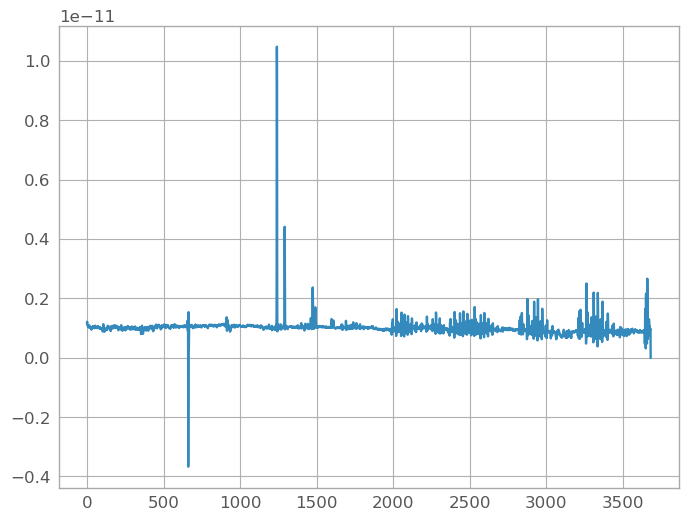

In [33]:
flux1 = np.nansum(binned_signal, axis=(1,2))
plt.plot(flux1)

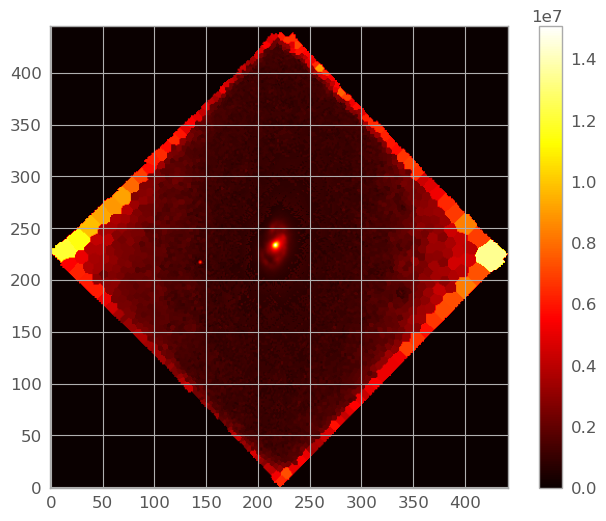

In [27]:
#To visualize new cube 
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

new_cube_im = np.nansum(new_cube, axis=0)
image_2D = np.squeeze(new_cube_im) 

plt.figure()
plt.imshow(image_2D, cmap='hot', origin = 'lower')
plt.colorbar()

(446, 442) (446, 442) (446, 442)


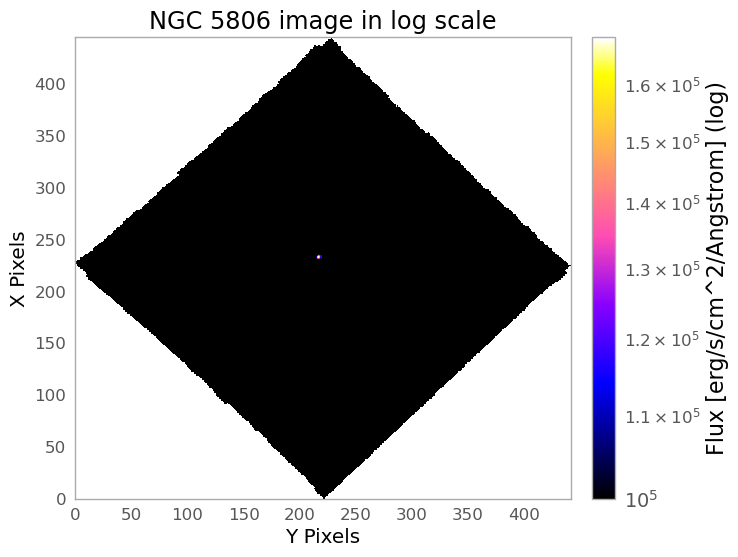

In [34]:
from matplotlib.colors import LogNorm
#Plot image in log:
vectorx = np.arange(nx)  
vectory = np.arange(ny) 
X,Y = np.meshgrid(vectorx, vectory)
Z = image_2D
print(X.shape,Y.shape,Z.shape)


fig = plt.figure(figsize=(7,6))
im = plt.pcolormesh(X,Y,Z, norm=LogNorm(vmin=(10**5)), cmap='gnuplot2',rasterized=True, shading='auto')


plt.xlabel('Y Pixels')
plt.ylabel('X Pixels')
plt.title('NGC 5806 image in log scale')
cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Flux [erg/s/cm^2/Angstrom] (log)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

In [68]:
flux1 = new_cube[:,:,:] 
flux1 = np.delete(flux1,1)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [58]:
wave = ((crdelt3 * (np.arange(0, nz-1, 1))) + crval3) 

Text(0.5, 1.0, 'Spectrum of whole image NGC 5806')

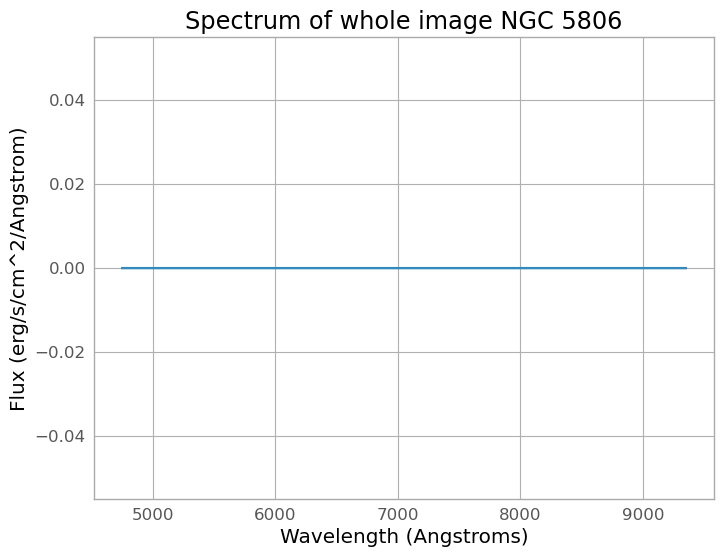

In [59]:
plt.figure(0)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.plot(wave, flux1)
plt.title('Spectrum of whole image NGC 5806')

In [10]:
#Trying sigma clipping to remove outliers
#If works, should add BEFORE binning
from astropy.stats import sigma_clip
filt_sig = sigma_clip(cube, sigma = 5,axis=0)

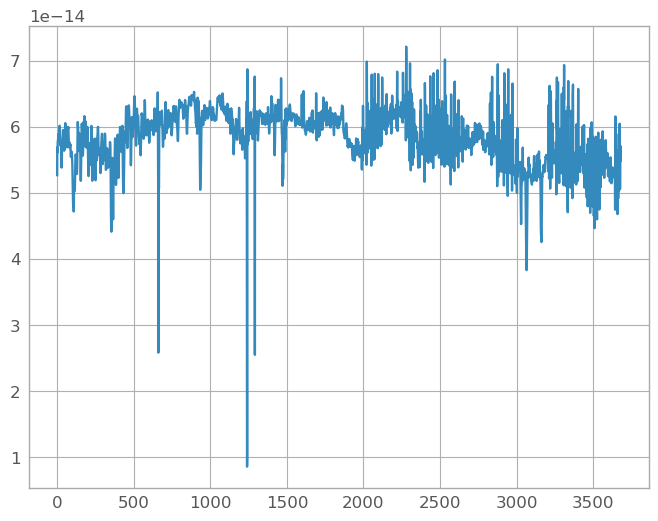

In [11]:
flux1 = np.nansum(filt_sig, axis=(1, 2)) * (10**(-20)) 
flux1 = np.delete(flux1, len(flux1)-1) #Remove one bad data point from the end of the spectral data

plt.plot(flux1)
